In [3]:
import pandas as pd
import numpy as np
from collections import defaultdict
import networkx as nx
from sklearn.model_selection import GroupShuffleSplit
from complex_group_split import ProteinComplexGroupSplitter

In [1]:
! which conda

In [4]:
def assign_same_complex_multi(df):
    """
    Assigns Same_Complex_Multi = 1 for gene pairs that co-occur in at least one complex.
    Adds a unique gene pair ID and preserves all original rows.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns:
            - 'Gene_A', 'Gene_B'
            - 'complex_id_A', 'complex_id_B'

    Returns
    -------
    pd.DataFrame
        Original DataFrame with:
            - 'pair_id': unique unordered gene pair ID
            - 'pairwise_label': 1 if complex_id_A == complex_id_B else 0
            - 'Same_Complex_Multi': 1 if the pair co-occurred in any complex, else 0
    """
    df = df.copy()

    # Canonicalize gene pair order
    df['Gene_1'] = df[['Gene_A', 'Gene_B']].min(axis=1)
    df['Gene_2'] = df[['Gene_A', 'Gene_B']].max(axis=1)

    display(df)

    # Create a unique pair ID
    df['pair_id'] = df['Gene_1'] + '_' + df['Gene_2']

    #display(df)
    display(df[['Gene_1', 'Gene_2', 'Gene_A', 'Gene_B', 'pair_id']])

    # Label whether this row is a within-complex match
    df['pairwise_label'] = (df['complex_id_A'] == df['complex_id_B']).astype(int)
    display(df)

    # Flag any pair ID with at least one match
    pair_to_label = df.groupby('pair_id')['pairwise_label'].sum() >= 1
    df['Same_Complex_Multi'] = df['pair_id'].map(pair_to_label).astype(int)
    display(df[['Gene_1', 'Gene_2', 'Gene_A', 'Gene_B', 'pair_id', 'pairwise_label', 'Same_Complex_Multi']])

    return df

In [5]:
splitter = ProteinComplexGroupSplitter()

In [6]:
df = pd.DataFrame()

for i in range(0, 5):
    fold = str(i + 1)
    
    sample = pd.read_csv(f'./balanced_sample/balanced_fold_{fold}.csv')
    df = pd.concat([df, sample])

df = df.drop_duplicates()
df = df.dropna()
df

,Unnamed: 0,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,Test
1,1,1028358,0.068281,0.095641,0.052614,-0.003973,0.024002,0.026690,0.001519,0.053231,0.512591,0.124054,0.855950,0.895115,0.860782,0.258649,0,False
2,2,1076714,-0.068618,0.055220,0.029123,-0.012644,-0.054653,0.104500,-0.025205,0.029771,0.296399,0.046220,0.801278,0.876071,0.799759,0.280591,0,False
3,3,1149031,0.055430,0.089606,-0.032863,0.093886,0.092885,-0.027436,0.014669,-0.032916,0.348519,0.160719,0.728447,0.846240,0.745176,0.268969,0,False
4,4,1160625,0.064023,-0.010588,-0.060429,-0.029586,-0.129990,-0.106961,-0.082286,-0.060440,0.204620,0.125283,0.631981,0.731705,0.645047,0.229455,0,False
5,5,1175960,-0.075059,0.077444,-0.072458,-0.056709,-0.019634,-0.143998,-0.029401,-0.076979,0.282250,0.215286,0.769158,0.832823,0.794798,0.098947,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19857,3967,197782715,0.026027,-0.017016,0.010061,-0.044468,0.008732,-0.002609,-0.035154,0.012923,0.285864,0.138036,0.811203,0.852404,0.786145,0.194006,0,True
19858,3968,197801788,-0.013131,-0.001935,-0.022772,-0.102259,-0.035392,-0.035508,-0.023197,-0.019972,0.350892,0.280877,0.804296,0.819977,0.745379,0.116762,0,True
19859,3969,197843269,0.021105,0.015475,-0.003376,0.001706,0.054092,0.109003,-0.046050,0.004031,0.114882,0.069295,0.556203,0.671250,0.403060,0.187668,0,True
19860,3970,198060465,0.081903,0.055526,0.087374,-0.019540,0.000730,0.058350,-0.042125,0.087813,0.531043,0.242083,0.677403,0.646955,0.561521,-0.038994,0,True


In [7]:
df[['global_index','Same_Complex']].drop_duplicates()

,global_index,Same_Complex
1,1028358,0
2,1076714,0
3,1149031,0
4,1160625,0
5,1175960,0
...,...,...
19857,197782715,0
19858,197801788,0
19859,197843269,0
19860,198060465,0


In [8]:
gp = pd.read_pickle('/home/ubuntu/scgpt_split_outputs/gene_pairs.pkl')

In [9]:
gp

,Gene_A,Gene_B
0,ST13P4,WASH2P
1,ST13P4,FAM90A12P
2,ST13P4,PI4KAP1
3,ST13P4,SNX29P2
4,ST13P4,ZNF818P
...,...,...
200794870,RBMXP1,PPT1
200794871,RBMXP1,PLD2
200794872,RBMXP1,EIF4EBP1
200794873,RBMXP1,TINAG


In [10]:
gp = gp.reset_index()
gp = gp.rename(columns={'index':'global_index'})

In [11]:
dataframe = df.merge(gp, on = 'global_index')

In [12]:
gene_complex_df = pd.read_csv('gene_complex_link.csv')

In [13]:
gene_complex_df_a = gene_complex_df.rename(columns={'gene_name':'Gene_A', 'complex_id':'complex_id_A'})

In [14]:
gene_complex_df_a.columns

Index(['Gene_A', 'complex_id_A'], dtype='object')

In [15]:
dataframe.drop(columns=['Unnamed: 0', 'Test'],inplace=True)

In [16]:
dataframe.shape

(98065, 18)

In [17]:
gene_complex_df_a

,Gene_A,complex_id_A
0,SMAD3,CPX-1
1,SMAD4,CPX-1
2,SMAD2,CPX-1
3,CREB1,CPX-8
4,ATF4,CPX-8
...,...,...
8807,FBXL2,CPX-3292
8808,RBX1,CPX-3295
8809,SKP1,CPX-3295
8810,SKP2,CPX-3295


In [18]:
gca = gene_complex_df_a.merge(dataframe, on = 'Gene_A', how = 'right') #.drop_duplicates(subset='complex_id')

In [19]:
gca

,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,Gene_B
0,PUS7L,NaN,1028358,0.068281,0.095641,0.052614,-0.003973,0.024002,0.026690,0.001519,0.053231,0.512591,0.124054,0.855950,0.895115,0.860782,0.258649,0,PUS10
1,PTPRU,NaN,1076714,-0.068618,0.055220,0.029123,-0.012644,-0.054653,0.104500,-0.025205,0.029771,0.296399,0.046220,0.801278,0.876071,0.799759,0.280591,0,RAB21
2,PTPRO,NaN,1149031,0.055430,0.089606,-0.032863,0.093886,0.092885,-0.027436,0.014669,-0.032916,0.348519,0.160719,0.728447,0.846240,0.745176,0.268969,0,ZNF324B
3,PTPRG,NaN,1160625,0.064023,-0.010588,-0.060429,-0.029586,-0.129990,-0.106961,-0.082286,-0.060440,0.204620,0.125283,0.631981,0.731705,0.645047,0.229455,0,CMTR2
4,PTPRE,NaN,1175960,-0.075059,0.077444,-0.072458,-0.056709,-0.019634,-0.143998,-0.029401,-0.076979,0.282250,0.215286,0.769158,0.832823,0.794798,0.098947,0,MIOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181631,TRPC5,CPX-25775,197801788,-0.013131,-0.001935,-0.022772,-0.102259,-0.035392,-0.035508,-0.023197,-0.019972,0.350892,0.280877,0.804296,0.819977,0.745379,0.116762,0,HBEGF
181632,TRPC5,CPX-25776,197801788,-0.013131,-0.001935,-0.022772,-0.102259,-0.035392,-0.035508,-0.023197,-0.019972,0.350892,0.280877,0.804296,0.819977,0.745379,0.116762,0,HBEGF
181633,APOA1,NaN,197843269,0.021105,0.015475,-0.003376,0.001706,0.054092,0.109003,-0.046050,0.004031,0.114882,0.069295,0.556203,0.671250,0.403060,0.187668,0,UQCC2
181634,PRKACG,NaN,198060465,0.081903,0.055526,0.087374,-0.019540,0.000730,0.058350,-0.042125,0.087813,0.531043,0.242083,0.677403,0.646955,0.561521,-0.038994,0,CLBA1


In [20]:
gene_complex_df_b = gene_complex_df.rename(columns={'gene_name':'Gene_B', 'complex_id':'complex_id_B'})

In [21]:
gcab =gene_complex_df_b.merge(gca, on = 'Gene_B', how = 'right')

In [22]:
gcabLite = gcab[['Gene_A', 'Gene_B', 'complex_id_A', 'complex_id_B', 'Same_Complex']].drop_duplicates()

In [23]:
gcabLite.shape

(225332, 5)

In [24]:
gcabLite[gcabLite['Same_Complex']==1].dropna()

,Gene_A,Gene_B,complex_id_A,complex_id_B,Same_Complex
9,SMC4,NCAPH,CPX-979,CPX-979,1
10,SMC4,NCAPH,CPX-985,CPX-979,1
19,SMC4,NCAPD2,CPX-979,CPX-979,1
20,SMC4,NCAPD2,CPX-985,CPX-979,1
29,SMC4,SMC2,CPX-979,CPX-979,1
...,...,...,...,...,...
727176,SMARCD2,SMARCD3,CPX-1228,CPX-1224,1
727177,SMARCD2,SMARCD3,CPX-1228,CPX-1225,1
727178,SMARCD2,SMARCD3,CPX-1228,CPX-1226,1
727179,SMARCD2,SMARCD3,CPX-1228,CPX-1227,1


In [25]:
gcabLite[gcabLite['Same_Complex']==0].dropna()

,Gene_A,Gene_B,complex_id_A,complex_id_B,Same_Complex
23076,PRKAB1,LAS1L,CPX-5633,CPX-8081,0
23077,PRKAB1,LAS1L,CPX-5786,CPX-8081,0
23078,PRKAB1,LAS1L,CPX-5787,CPX-8081,0
23079,PRKAB1,LAS1L,CPX-5842,CPX-8081,0
23080,PRKAB1,LAS1L,CPX-5843,CPX-8081,0
...,...,...,...,...,...
793642,PSMB10,AGO1,CPX-9003,CPX-8624,0
793643,PSMB10,AGO1,CPX-9003,CPX-8625,0
793644,PSMB10,AGO1,CPX-9004,CPX-8623,0
793645,PSMB10,AGO1,CPX-9004,CPX-8624,0


In [26]:
gcabLite[(gcabLite['complex_id_A'].isna()) & (gcabLite['complex_id_B'].isna())]

,Gene_A,Gene_B,complex_id_A,complex_id_B,Same_Complex
0,PUS7L,PUS10,NaN,NaN,0
1,PTPRU,RAB21,NaN,NaN,0
2,PTPRO,ZNF324B,NaN,NaN,0
3,PTPRG,CMTR2,NaN,NaN,0
5,NMI,RHOB,NaN,NaN,0
...,...,...,...,...,...
793657,AKAP12,ATM,NaN,NaN,0
793658,ZFP41,LCMT1,NaN,NaN,0
793662,APOA1,UQCC2,NaN,NaN,0
793663,PRKACG,CLBA1,NaN,NaN,0


In [27]:
gcabLite[(gcabLite['Gene_A']=='ISY1') & (gcabLite['Gene_B']=='DHX38')]

,Gene_A,Gene_B,complex_id_A,complex_id_B,Same_Complex
755303,ISY1,DHX38,CPX-8065,CPX-26463,0
755304,ISY1,DHX38,CPX-26463,CPX-26463,0


In [31]:
gcab

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex
0,PUS10,NaN,PUS7L,NaN,1028358,0.068281,0.095641,0.052614,-0.003973,0.024002,0.026690,0.001519,0.053231,0.512591,0.124054,0.855950,0.895115,0.860782,0.258649,0
1,RAB21,NaN,PTPRU,NaN,1076714,-0.068618,0.055220,0.029123,-0.012644,-0.054653,0.104500,-0.025205,0.029771,0.296399,0.046220,0.801278,0.876071,0.799759,0.280591,0
2,ZNF324B,NaN,PTPRO,NaN,1149031,0.055430,0.089606,-0.032863,0.093886,0.092885,-0.027436,0.014669,-0.032916,0.348519,0.160719,0.728447,0.846240,0.745176,0.268969,0
3,CMTR2,NaN,PTPRG,NaN,1160625,0.064023,-0.010588,-0.060429,-0.029586,-0.129990,-0.106961,-0.082286,-0.060440,0.204620,0.125283,0.631981,0.731705,0.645047,0.229455,0
4,MIOS,CPX-6227,PTPRE,NaN,1175960,-0.075059,0.077444,-0.072458,-0.056709,-0.019634,-0.143998,-0.029401,-0.076979,0.282250,0.215286,0.769158,0.832823,0.794798,0.098947,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793660,HBEGF,NaN,TRPC5,CPX-25775,197801788,-0.013131,-0.001935,-0.022772,-0.102259,-0.035392,-0.035508,-0.023197,-0.019972,0.350892,0.280877,0.804296,0.819977,0.745379,0.116762,0
793661,HBEGF,NaN,TRPC5,CPX-25776,197801788,-0.013131,-0.001935,-0.022772,-0.102259,-0.035392,-0.035508,-0.023197,-0.019972,0.350892,0.280877,0.804296,0.819977,0.745379,0.116762,0
793662,UQCC2,NaN,APOA1,NaN,197843269,0.021105,0.015475,-0.003376,0.001706,0.054092,0.109003,-0.046050,0.004031,0.114882,0.069295,0.556203,0.671250,0.403060,0.187668,0
793663,CLBA1,NaN,PRKACG,NaN,198060465,0.081903,0.055526,0.087374,-0.019540,0.000730,0.058350,-0.042125,0.087813,0.531043,0.242083,0.677403,0.646955,0.561521,-0.038994,0


In [32]:
gcab = gcab.drop_duplicates()

In [33]:
#df = gcab.copy()
# Standardize gene pair ordering to ensure unique keys
df['Gene_1'] = df[['Gene_A', 'Gene_B']].min(axis=1)
df['Gene_2'] = df[['Gene_A', 'Gene_B']].max(axis=1)



KeyError: "None of [Index(['Gene_A', 'Gene_B'], dtype='object')] are in the [columns]"

In [92]:
df

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,Gene_1,Gene_2
755303,DHX38,CPX-26463,ISY1,CPX-8065,155455135,0.087646,0.233275,0.211102,0.057701,0.055155,...,0.212098,0.300938,0.289589,0.83599,0.877611,0.883893,0.486375,0,DHX38,ISY1
755304,DHX38,CPX-26463,ISY1,CPX-26463,155455135,0.087646,0.233275,0.211102,0.057701,0.055155,...,0.212098,0.300938,0.289589,0.83599,0.877611,0.883893,0.486375,0,DHX38,ISY1


In [80]:
gcab.shape == df.shape

False

In [81]:
gcab.shape[0] == df.shape[0]

True

In [93]:
    # Label each row with whether the genes co-occur in the same complex
df['pairwise_label'] = (df['complex_id_A'] == df['complex_id_B']).astype(int)

In [94]:
df

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,Gene_1,Gene_2,pairwise_label
755303,DHX38,CPX-26463,ISY1,CPX-8065,155455135,0.087646,0.233275,0.211102,0.057701,0.055155,...,0.300938,0.289589,0.83599,0.877611,0.883893,0.486375,0,DHX38,ISY1,0
755304,DHX38,CPX-26463,ISY1,CPX-26463,155455135,0.087646,0.233275,0.211102,0.057701,0.055155,...,0.300938,0.289589,0.83599,0.877611,0.883893,0.486375,0,DHX38,ISY1,1


In [83]:
gcab.shape == df.shape

False

In [84]:
gcab.shape[0] == df.shape[0]

True

In [34]:
gcab

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex
0,PUS10,NaN,PUS7L,NaN,1028358,0.068281,0.095641,0.052614,-0.003973,0.024002,0.026690,0.001519,0.053231,0.512591,0.124054,0.855950,0.895115,0.860782,0.258649,0
1,RAB21,NaN,PTPRU,NaN,1076714,-0.068618,0.055220,0.029123,-0.012644,-0.054653,0.104500,-0.025205,0.029771,0.296399,0.046220,0.801278,0.876071,0.799759,0.280591,0
2,ZNF324B,NaN,PTPRO,NaN,1149031,0.055430,0.089606,-0.032863,0.093886,0.092885,-0.027436,0.014669,-0.032916,0.348519,0.160719,0.728447,0.846240,0.745176,0.268969,0
3,CMTR2,NaN,PTPRG,NaN,1160625,0.064023,-0.010588,-0.060429,-0.029586,-0.129990,-0.106961,-0.082286,-0.060440,0.204620,0.125283,0.631981,0.731705,0.645047,0.229455,0
4,MIOS,CPX-6227,PTPRE,NaN,1175960,-0.075059,0.077444,-0.072458,-0.056709,-0.019634,-0.143998,-0.029401,-0.076979,0.282250,0.215286,0.769158,0.832823,0.794798,0.098947,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793660,HBEGF,NaN,TRPC5,CPX-25775,197801788,-0.013131,-0.001935,-0.022772,-0.102259,-0.035392,-0.035508,-0.023197,-0.019972,0.350892,0.280877,0.804296,0.819977,0.745379,0.116762,0
793661,HBEGF,NaN,TRPC5,CPX-25776,197801788,-0.013131,-0.001935,-0.022772,-0.102259,-0.035392,-0.035508,-0.023197,-0.019972,0.350892,0.280877,0.804296,0.819977,0.745379,0.116762,0
793662,UQCC2,NaN,APOA1,NaN,197843269,0.021105,0.015475,-0.003376,0.001706,0.054092,0.109003,-0.046050,0.004031,0.114882,0.069295,0.556203,0.671250,0.403060,0.187668,0
793663,CLBA1,NaN,PRKACG,NaN,198060465,0.081903,0.055526,0.087374,-0.019540,0.000730,0.058350,-0.042125,0.087813,0.531043,0.242083,0.677403,0.646955,0.561521,-0.038994,0


In [86]:
df.shape

(225332, 23)

In [87]:
grouped = (
        df.groupby(['Gene_1', 'Gene_2'])['pairwise_label']
        .max()
        .reset_index()
        .rename(columns={'Gene_1': 'Gene_A', 'Gene_2': 'Gene_B', 'pairwise_label': 'Same_Complex'})
)

In [59]:
grouped

,Gene_A,Gene_B,Same_Complex
0,A1BG,AGAP3,0
1,A1BG,ISOC1,0
2,A1BG,PPP1R16A,0
3,A1BG,RNF181,0
4,A1BG,TOP2B,0
...,...,...,...
58964,ZNF696,ZNF827,0
58965,ZNF771,ZNF783,0
58966,ZNF790,ZNF846,0
58967,ZNF853,ZSCAN31,0


In [97]:
df = gcab[(gcab['Gene_A']=='ISY1') & (gcab['Gene_B']=='DHX38')].copy()

In [88]:
grouped[(grouped['Gene_A']=='ISY1') & (grouped['Gene_B']=='DHX38')]

,Gene_A,Gene_B,Same_Complex


In [61]:
grouped['Same_Complex'].value_counts()

0    49040
1     9929
Name: Same_Complex, dtype: int64

In [100]:
assign_same_complex_multi(df)

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,Gene_1,Gene_2
755303,DHX38,CPX-26463,ISY1,CPX-8065,155455135,0.087646,0.233275,0.211102,0.057701,0.055155,...,0.212098,0.300938,0.289589,0.83599,0.877611,0.883893,0.486375,0,DHX38,ISY1
755304,DHX38,CPX-26463,ISY1,CPX-26463,155455135,0.087646,0.233275,0.211102,0.057701,0.055155,...,0.212098,0.300938,0.289589,0.83599,0.877611,0.883893,0.486375,0,DHX38,ISY1


,Gene_1,Gene_2,Gene_A,Gene_B,pair_id
755303,DHX38,ISY1,ISY1,DHX38,DHX38_ISY1
755304,DHX38,ISY1,ISY1,DHX38,DHX38_ISY1


,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,Gene_1,Gene_2,pair_id,pairwise_label
755303,DHX38,CPX-26463,ISY1,CPX-8065,155455135,0.087646,0.233275,0.211102,0.057701,0.055155,...,0.289589,0.83599,0.877611,0.883893,0.486375,0,DHX38,ISY1,DHX38_ISY1,0
755304,DHX38,CPX-26463,ISY1,CPX-26463,155455135,0.087646,0.233275,0.211102,0.057701,0.055155,...,0.289589,0.83599,0.877611,0.883893,0.486375,0,DHX38,ISY1,DHX38_ISY1,1


,Gene_1,Gene_2,Gene_A,Gene_B,pair_id,pairwise_label,Same_Complex_Multi
755303,DHX38,ISY1,ISY1,DHX38,DHX38_ISY1,0,1
755304,DHX38,ISY1,ISY1,DHX38,DHX38_ISY1,1,1


,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex_Multi
755303,DHX38,CPX-26463,ISY1,CPX-8065,155455135,0.087646,0.233275,0.211102,0.057701,0.055155,...,0.83599,0.877611,0.883893,0.486375,0,DHX38,ISY1,DHX38_ISY1,0,1
755304,DHX38,CPX-26463,ISY1,CPX-26463,155455135,0.087646,0.233275,0.211102,0.057701,0.055155,...,0.83599,0.877611,0.883893,0.486375,0,DHX38,ISY1,DHX38_ISY1,1,1


In [101]:
gcab

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex
0,PUS10,NaN,PUS7L,NaN,1028358,0.068281,0.095641,0.052614,-0.003973,0.024002,0.026690,0.001519,0.053231,0.512591,0.124054,0.855950,0.895115,0.860782,0.258649,0
1,RAB21,NaN,PTPRU,NaN,1076714,-0.068618,0.055220,0.029123,-0.012644,-0.054653,0.104500,-0.025205,0.029771,0.296399,0.046220,0.801278,0.876071,0.799759,0.280591,0
2,ZNF324B,NaN,PTPRO,NaN,1149031,0.055430,0.089606,-0.032863,0.093886,0.092885,-0.027436,0.014669,-0.032916,0.348519,0.160719,0.728447,0.846240,0.745176,0.268969,0
3,CMTR2,NaN,PTPRG,NaN,1160625,0.064023,-0.010588,-0.060429,-0.029586,-0.129990,-0.106961,-0.082286,-0.060440,0.204620,0.125283,0.631981,0.731705,0.645047,0.229455,0
4,MIOS,CPX-6227,PTPRE,NaN,1175960,-0.075059,0.077444,-0.072458,-0.056709,-0.019634,-0.143998,-0.029401,-0.076979,0.282250,0.215286,0.769158,0.832823,0.794798,0.098947,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793660,HBEGF,NaN,TRPC5,CPX-25775,197801788,-0.013131,-0.001935,-0.022772,-0.102259,-0.035392,-0.035508,-0.023197,-0.019972,0.350892,0.280877,0.804296,0.819977,0.745379,0.116762,0
793661,HBEGF,NaN,TRPC5,CPX-25776,197801788,-0.013131,-0.001935,-0.022772,-0.102259,-0.035392,-0.035508,-0.023197,-0.019972,0.350892,0.280877,0.804296,0.819977,0.745379,0.116762,0
793662,UQCC2,NaN,APOA1,NaN,197843269,0.021105,0.015475,-0.003376,0.001706,0.054092,0.109003,-0.046050,0.004031,0.114882,0.069295,0.556203,0.671250,0.403060,0.187668,0
793663,CLBA1,NaN,PRKACG,NaN,198060465,0.081903,0.055526,0.087374,-0.019540,0.000730,0.058350,-0.042125,0.087813,0.531043,0.242083,0.677403,0.646955,0.561521,-0.038994,0


In [35]:
_gcab = assign_same_complex_multi(gcab)

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,Gene_1,Gene_2
0,PUS10,NaN,PUS7L,NaN,1028358,0.068281,0.095641,0.052614,-0.003973,0.024002,...,0.053231,0.512591,0.124054,0.855950,0.895115,0.860782,0.258649,0,PUS10,PUS7L
1,RAB21,NaN,PTPRU,NaN,1076714,-0.068618,0.055220,0.029123,-0.012644,-0.054653,...,0.029771,0.296399,0.046220,0.801278,0.876071,0.799759,0.280591,0,PTPRU,RAB21
2,ZNF324B,NaN,PTPRO,NaN,1149031,0.055430,0.089606,-0.032863,0.093886,0.092885,...,-0.032916,0.348519,0.160719,0.728447,0.846240,0.745176,0.268969,0,PTPRO,ZNF324B
3,CMTR2,NaN,PTPRG,NaN,1160625,0.064023,-0.010588,-0.060429,-0.029586,-0.129990,...,-0.060440,0.204620,0.125283,0.631981,0.731705,0.645047,0.229455,0,CMTR2,PTPRG
4,MIOS,CPX-6227,PTPRE,NaN,1175960,-0.075059,0.077444,-0.072458,-0.056709,-0.019634,...,-0.076979,0.282250,0.215286,0.769158,0.832823,0.794798,0.098947,0,MIOS,PTPRE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793660,HBEGF,NaN,TRPC5,CPX-25775,197801788,-0.013131,-0.001935,-0.022772,-0.102259,-0.035392,...,-0.019972,0.350892,0.280877,0.804296,0.819977,0.745379,0.116762,0,HBEGF,TRPC5
793661,HBEGF,NaN,TRPC5,CPX-25776,197801788,-0.013131,-0.001935,-0.022772,-0.102259,-0.035392,...,-0.019972,0.350892,0.280877,0.804296,0.819977,0.745379,0.116762,0,HBEGF,TRPC5
793662,UQCC2,NaN,APOA1,NaN,197843269,0.021105,0.015475,-0.003376,0.001706,0.054092,...,0.004031,0.114882,0.069295,0.556203,0.671250,0.403060,0.187668,0,APOA1,UQCC2
793663,CLBA1,NaN,PRKACG,NaN,198060465,0.081903,0.055526,0.087374,-0.019540,0.000730,...,0.087813,0.531043,0.242083,0.677403,0.646955,0.561521,-0.038994,0,CLBA1,PRKACG


,Gene_1,Gene_2,Gene_A,Gene_B,pair_id
0,PUS10,PUS7L,PUS7L,PUS10,PUS10_PUS7L
1,PTPRU,RAB21,PTPRU,RAB21,PTPRU_RAB21
2,PTPRO,ZNF324B,PTPRO,ZNF324B,PTPRO_ZNF324B
3,CMTR2,PTPRG,PTPRG,CMTR2,CMTR2_PTPRG
4,MIOS,PTPRE,PTPRE,MIOS,MIOS_PTPRE
...,...,...,...,...,...
793660,HBEGF,TRPC5,TRPC5,HBEGF,HBEGF_TRPC5
793661,HBEGF,TRPC5,TRPC5,HBEGF,HBEGF_TRPC5
793662,APOA1,UQCC2,APOA1,UQCC2,APOA1_UQCC2
793663,CLBA1,PRKACG,PRKACG,CLBA1,CLBA1_PRKACG


,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,Gene_1,Gene_2,pair_id,pairwise_label
0,PUS10,NaN,PUS7L,NaN,1028358,0.068281,0.095641,0.052614,-0.003973,0.024002,...,0.124054,0.855950,0.895115,0.860782,0.258649,0,PUS10,PUS7L,PUS10_PUS7L,0
1,RAB21,NaN,PTPRU,NaN,1076714,-0.068618,0.055220,0.029123,-0.012644,-0.054653,...,0.046220,0.801278,0.876071,0.799759,0.280591,0,PTPRU,RAB21,PTPRU_RAB21,0
2,ZNF324B,NaN,PTPRO,NaN,1149031,0.055430,0.089606,-0.032863,0.093886,0.092885,...,0.160719,0.728447,0.846240,0.745176,0.268969,0,PTPRO,ZNF324B,PTPRO_ZNF324B,0
3,CMTR2,NaN,PTPRG,NaN,1160625,0.064023,-0.010588,-0.060429,-0.029586,-0.129990,...,0.125283,0.631981,0.731705,0.645047,0.229455,0,CMTR2,PTPRG,CMTR2_PTPRG,0
4,MIOS,CPX-6227,PTPRE,NaN,1175960,-0.075059,0.077444,-0.072458,-0.056709,-0.019634,...,0.215286,0.769158,0.832823,0.794798,0.098947,0,MIOS,PTPRE,MIOS_PTPRE,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793660,HBEGF,NaN,TRPC5,CPX-25775,197801788,-0.013131,-0.001935,-0.022772,-0.102259,-0.035392,...,0.280877,0.804296,0.819977,0.745379,0.116762,0,HBEGF,TRPC5,HBEGF_TRPC5,0
793661,HBEGF,NaN,TRPC5,CPX-25776,197801788,-0.013131,-0.001935,-0.022772,-0.102259,-0.035392,...,0.280877,0.804296,0.819977,0.745379,0.116762,0,HBEGF,TRPC5,HBEGF_TRPC5,0
793662,UQCC2,NaN,APOA1,NaN,197843269,0.021105,0.015475,-0.003376,0.001706,0.054092,...,0.069295,0.556203,0.671250,0.403060,0.187668,0,APOA1,UQCC2,APOA1_UQCC2,0
793663,CLBA1,NaN,PRKACG,NaN,198060465,0.081903,0.055526,0.087374,-0.019540,0.000730,...,0.242083,0.677403,0.646955,0.561521,-0.038994,0,CLBA1,PRKACG,CLBA1_PRKACG,0


,Gene_1,Gene_2,Gene_A,Gene_B,pair_id,pairwise_label,Same_Complex_Multi
0,PUS10,PUS7L,PUS7L,PUS10,PUS10_PUS7L,0,0
1,PTPRU,RAB21,PTPRU,RAB21,PTPRU_RAB21,0,0
2,PTPRO,ZNF324B,PTPRO,ZNF324B,PTPRO_ZNF324B,0,0
3,CMTR2,PTPRG,PTPRG,CMTR2,CMTR2_PTPRG,0,0
4,MIOS,PTPRE,PTPRE,MIOS,MIOS_PTPRE,0,0
...,...,...,...,...,...,...,...
793660,HBEGF,TRPC5,TRPC5,HBEGF,HBEGF_TRPC5,0,0
793661,HBEGF,TRPC5,TRPC5,HBEGF,HBEGF_TRPC5,0,0
793662,APOA1,UQCC2,APOA1,UQCC2,APOA1_UQCC2,0,0
793663,CLBA1,PRKACG,PRKACG,CLBA1,CLBA1_PRKACG,0,0


In [115]:
_gcab[_gcab['Same_Complex_Multi']==0]

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex_Multi
0,PUS10,NaN,PUS7L,NaN,1028358,0.068281,0.095641,0.052614,-0.003973,0.024002,...,0.855950,0.895115,0.860782,0.258649,0,PUS10,PUS7L,PUS10_PUS7L,0,0
1,RAB21,NaN,PTPRU,NaN,1076714,-0.068618,0.055220,0.029123,-0.012644,-0.054653,...,0.801278,0.876071,0.799759,0.280591,0,PTPRU,RAB21,PTPRU_RAB21,0,0
2,ZNF324B,NaN,PTPRO,NaN,1149031,0.055430,0.089606,-0.032863,0.093886,0.092885,...,0.728447,0.846240,0.745176,0.268969,0,PTPRO,ZNF324B,PTPRO_ZNF324B,0,0
3,CMTR2,NaN,PTPRG,NaN,1160625,0.064023,-0.010588,-0.060429,-0.029586,-0.129990,...,0.631981,0.731705,0.645047,0.229455,0,CMTR2,PTPRG,CMTR2_PTPRG,0,0
4,MIOS,CPX-6227,PTPRE,NaN,1175960,-0.075059,0.077444,-0.072458,-0.056709,-0.019634,...,0.769158,0.832823,0.794798,0.098947,0,MIOS,PTPRE,MIOS_PTPRE,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793660,HBEGF,NaN,TRPC5,CPX-25775,197801788,-0.013131,-0.001935,-0.022772,-0.102259,-0.035392,...,0.804296,0.819977,0.745379,0.116762,0,HBEGF,TRPC5,HBEGF_TRPC5,0,0
793661,HBEGF,NaN,TRPC5,CPX-25776,197801788,-0.013131,-0.001935,-0.022772,-0.102259,-0.035392,...,0.804296,0.819977,0.745379,0.116762,0,HBEGF,TRPC5,HBEGF_TRPC5,0,0
793662,UQCC2,NaN,APOA1,NaN,197843269,0.021105,0.015475,-0.003376,0.001706,0.054092,...,0.556203,0.671250,0.403060,0.187668,0,APOA1,UQCC2,APOA1_UQCC2,0,0
793663,CLBA1,NaN,PRKACG,NaN,198060465,0.081903,0.055526,0.087374,-0.019540,0.000730,...,0.677403,0.646955,0.561521,-0.038994,0,CLBA1,PRKACG,CLBA1_PRKACG,0,0


In [116]:
_gcab[_gcab['pairwise_label']==1]

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex_Multi
9,NCAPH,CPX-979,SMC4,CPX-979,1233514,0.152572,0.278260,0.279285,0.086505,0.016837,...,0.818509,0.843800,0.791423,0.158144,1,NCAPH,SMC4,NCAPH_SMC4,1,1
19,NCAPD2,CPX-979,SMC4,CPX-979,1236971,0.212407,0.326606,0.342729,0.171613,0.107731,...,0.828535,0.852704,0.792023,0.048583,1,NCAPD2,SMC4,NCAPD2_SMC4,1,1
29,SMC2,CPX-979,SMC4,CPX-979,1248692,0.357727,0.429999,0.454932,0.100881,0.021302,...,0.796155,0.851008,0.836524,0.191937,1,SMC2,SMC4,SMC2_SMC4,1,1
32,SMC2,CPX-985,SMC4,CPX-985,1248692,0.357727,0.429999,0.454932,0.100881,0.021302,...,0.796155,0.851008,0.836524,0.191937,1,SMC2,SMC4,SMC2_SMC4,1,1
74,PSMD13,CPX-5993,PSMD4,CPX-5993,1704555,0.201559,0.408497,0.418062,0.195187,0.041542,...,0.769512,0.812227,0.785746,-0.054507,1,PSMD13,PSMD4,PSMD13_PSMD4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727105,SMARCD3,CPX-1225,SMARCD2,CPX-1225,198219403,0.061948,0.088651,0.107033,0.018593,-0.018117,...,0.831281,0.866889,0.849838,0.081792,1,SMARCD2,SMARCD3,SMARCD2_SMARCD3,1,1
727130,SMARCD3,CPX-1226,SMARCD2,CPX-1226,198219403,0.061948,0.088651,0.107033,0.018593,-0.018117,...,0.831281,0.866889,0.849838,0.081792,1,SMARCD2,SMARCD3,SMARCD2_SMARCD3,1,1
727155,SMARCD3,CPX-1227,SMARCD2,CPX-1227,198219403,0.061948,0.088651,0.107033,0.018593,-0.018117,...,0.831281,0.866889,0.849838,0.081792,1,SMARCD2,SMARCD3,SMARCD2_SMARCD3,1,1
727180,SMARCD3,CPX-1228,SMARCD2,CPX-1228,198219403,0.061948,0.088651,0.107033,0.018593,-0.018117,...,0.831281,0.866889,0.849838,0.081792,1,SMARCD2,SMARCD3,SMARCD2_SMARCD3,1,1


In [113]:
_gcab[_gcab['Same_Complex']==0]

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex_Multi
0,PUS10,NaN,PUS7L,NaN,1028358,0.068281,0.095641,0.052614,-0.003973,0.024002,...,0.855950,0.895115,0.860782,0.258649,0,PUS10,PUS7L,PUS10_PUS7L,0,0
1,RAB21,NaN,PTPRU,NaN,1076714,-0.068618,0.055220,0.029123,-0.012644,-0.054653,...,0.801278,0.876071,0.799759,0.280591,0,PTPRU,RAB21,PTPRU_RAB21,0,0
2,ZNF324B,NaN,PTPRO,NaN,1149031,0.055430,0.089606,-0.032863,0.093886,0.092885,...,0.728447,0.846240,0.745176,0.268969,0,PTPRO,ZNF324B,PTPRO_ZNF324B,0,0
3,CMTR2,NaN,PTPRG,NaN,1160625,0.064023,-0.010588,-0.060429,-0.029586,-0.129990,...,0.631981,0.731705,0.645047,0.229455,0,CMTR2,PTPRG,CMTR2_PTPRG,0,0
4,MIOS,CPX-6227,PTPRE,NaN,1175960,-0.075059,0.077444,-0.072458,-0.056709,-0.019634,...,0.769158,0.832823,0.794798,0.098947,0,MIOS,PTPRE,MIOS_PTPRE,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793660,HBEGF,NaN,TRPC5,CPX-25775,197801788,-0.013131,-0.001935,-0.022772,-0.102259,-0.035392,...,0.804296,0.819977,0.745379,0.116762,0,HBEGF,TRPC5,HBEGF_TRPC5,0,0
793661,HBEGF,NaN,TRPC5,CPX-25776,197801788,-0.013131,-0.001935,-0.022772,-0.102259,-0.035392,...,0.804296,0.819977,0.745379,0.116762,0,HBEGF,TRPC5,HBEGF_TRPC5,0,0
793662,UQCC2,NaN,APOA1,NaN,197843269,0.021105,0.015475,-0.003376,0.001706,0.054092,...,0.556203,0.671250,0.403060,0.187668,0,APOA1,UQCC2,APOA1_UQCC2,0,0
793663,CLBA1,NaN,PRKACG,NaN,198060465,0.081903,0.055526,0.087374,-0.019540,0.000730,...,0.677403,0.646955,0.561521,-0.038994,0,CLBA1,PRKACG,CLBA1_PRKACG,0,0


In [105]:
_gcab[(_gcab['Same_Complex']==1)&(_gcab['Same_Complex_Multi']==1)]

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex_Multi
9,NCAPH,CPX-979,SMC4,CPX-979,1233514,0.152572,0.278260,0.279285,0.086505,0.016837,...,0.818509,0.843800,0.791423,0.158144,1,NCAPH,SMC4,NCAPH_SMC4,1,1
10,NCAPH,CPX-979,SMC4,CPX-985,1233514,0.152572,0.278260,0.279285,0.086505,0.016837,...,0.818509,0.843800,0.791423,0.158144,1,NCAPH,SMC4,NCAPH_SMC4,0,1
19,NCAPD2,CPX-979,SMC4,CPX-979,1236971,0.212407,0.326606,0.342729,0.171613,0.107731,...,0.828535,0.852704,0.792023,0.048583,1,NCAPD2,SMC4,NCAPD2_SMC4,1,1
20,NCAPD2,CPX-979,SMC4,CPX-985,1236971,0.212407,0.326606,0.342729,0.171613,0.107731,...,0.828535,0.852704,0.792023,0.048583,1,NCAPD2,SMC4,NCAPD2_SMC4,0,1
29,SMC2,CPX-979,SMC4,CPX-979,1248692,0.357727,0.429999,0.454932,0.100881,0.021302,...,0.796155,0.851008,0.836524,0.191937,1,SMC2,SMC4,SMC2_SMC4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727176,SMARCD3,CPX-1224,SMARCD2,CPX-1228,198219403,0.061948,0.088651,0.107033,0.018593,-0.018117,...,0.831281,0.866889,0.849838,0.081792,1,SMARCD2,SMARCD3,SMARCD2_SMARCD3,0,1
727177,SMARCD3,CPX-1225,SMARCD2,CPX-1228,198219403,0.061948,0.088651,0.107033,0.018593,-0.018117,...,0.831281,0.866889,0.849838,0.081792,1,SMARCD2,SMARCD3,SMARCD2_SMARCD3,0,1
727178,SMARCD3,CPX-1226,SMARCD2,CPX-1228,198219403,0.061948,0.088651,0.107033,0.018593,-0.018117,...,0.831281,0.866889,0.849838,0.081792,1,SMARCD2,SMARCD3,SMARCD2_SMARCD3,0,1
727179,SMARCD3,CPX-1227,SMARCD2,CPX-1228,198219403,0.061948,0.088651,0.107033,0.018593,-0.018117,...,0.831281,0.866889,0.849838,0.081792,1,SMARCD2,SMARCD3,SMARCD2_SMARCD3,0,1


In [36]:
_gcab[['Gene_A', 'Gene_B', 'Same_Complex_Multi']].drop_duplicates()

,Gene_A,Gene_B,Same_Complex_Multi
0,PUS7L,PUS10,0
1,PTPRU,RAB21,0
2,PTPRO,ZNF324B,0
3,PTPRG,CMTR2,0
4,PTPRE,MIOS,0
...,...,...,...
793658,ZFP41,LCMT1,0
793659,TRPC5,HBEGF,0
793662,APOA1,UQCC2,0
793663,PRKACG,CLBA1,0


In [37]:
_gcab.drop(columns=['Same_Complex'],inplace=True)

In [38]:
_gcab.rename(columns={'Same_Complex_Multi':'Same_Complex'},inplace=True)

In [39]:
class ProteinComplexGroupSplitter:
    def __init__(self, positive_label=1, negative_ratio=3, random_state=42):
        self.positive_label = positive_label
        self.negative_ratio = negative_ratio
        self.random_state = random_state
        self.supergroup_map = {}
        self.positive_df = None
        self.negative_df = None
        self.full_df = None

    def _extract_positive_pairs(self, df):
        pos_df = df[df['Same_Complex'] == self.positive_label].copy()
        pos_df['complex_pair'] = pos_df.apply(
            lambda row: frozenset([row['complex_id_A'], row['complex_id_B']]), axis=1
        )
        return pos_df

    def _build_supergroups(self, pos_df):
        g = nx.Graph()
        for cpair in pos_df['complex_pair']:
            g.add_nodes_from(cpair)
            for a in cpair:
                for b in cpair:
                    if a != b:
                        g.add_edge(a, b)

        supergroups = list(nx.connected_components(g))
        complex_to_supergroup = {}
        for i, sg in enumerate(supergroups):
            for complex_id in sg:
                complex_to_supergroup[complex_id] = i

        pos_df['group_id'] = pos_df.apply(
            lambda row: complex_to_supergroup.get(row['complex_id_A'], -1), axis=1
        )
        return pos_df, complex_to_supergroup

    def _assign_negative_groups(self, df, pos_group_ids):
        neg_df = df[df['Same_Complex'] != self.positive_label].copy()
        sample_size = min(len(neg_df), self.negative_ratio * len(self.positive_df))
        neg_df = neg_df.sample(n=sample_size, random_state=self.random_state).copy()
        neg_df['group_id'] = np.random.choice(pos_group_ids, size=len(neg_df), replace=True)
        return neg_df

    def prepare(self, df):
        self.positive_df = self._extract_positive_pairs(df)
        self.positive_df, self.supergroup_map = self._build_supergroups(self.positive_df)
        pos_group_ids = self.positive_df['group_id'].unique()
        self.negative_df = self._assign_negative_groups(df, pos_group_ids)
        self.full_df = pd.concat([self.positive_df, self.negative_df], ignore_index=True)
        return self.full_df

    def group_split(self, test_size=0.25):
        if self.full_df is None:
            raise ValueError("Run `prepare(df)` first to generate group assignments.")

        X = self.full_df.drop(columns=['Same_Complex'])
        y = self.full_df['Same_Complex']
        groups = self.full_df['group_id']

        gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=self.random_state)
        for train_idx, test_idx in gss.split(X, y, groups):
            return (
                X.iloc[train_idx], X.iloc[test_idx],
                y.iloc[train_idx], y.iloc[test_idx],
                groups.iloc[train_idx], groups.iloc[test_idx]
            )



In [40]:
splitter = ProteinComplexGroupSplitter()

In [41]:
prepared_df = splitter.prepare(_gcab)

In [42]:
prepared_df.to_csv('prepared_df.csv', index=False)

In [43]:
_gcab.shape

(225332, 24)

In [44]:
prepared_df['complex_pair'].value_counts()

(CPX-5183, CPX-7665)    1764
(CPX-5183, CPX-7664)    1722
(CPX-7665, CPX-7664)    1682
(CPX-5226)              1317
(CPX-9082, CPX-5993)    1056
                        ... 
(CPX-477, CPX-7929)        1
(CPX-2399, CPX-7929)       1
(CPX-7929, CPX-2403)       1
(CPX-2405, CPX-7929)       1
(CPX-10331)                1
Name: complex_pair, Length: 15635, dtype: int64

In [136]:
X_train, X_test, y_train, y_test, group_train, group_test = splitter.group_split(test_size=0.2)


In [137]:
group_train

8           1
9           1
10          1
11          1
12          1
         ... 
225322    311
225324     81
225326    152
225327    162
225328    115
Name: group_id, Length: 204890, dtype: int64

In [139]:
group_test

0           0
1           0
2           0
3           0
4           0
         ... 
225323     15
225325    140
225329     55
225330    148
225331     93
Name: group_id, Length: 20442, dtype: int64

In [140]:
X_test

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Gene_1,Gene_2,pair_id,pairwise_label,complex_pair,group_id
0,NCAPH,CPX-979,SMC4,CPX-979,1233514,0.152572,0.278260,0.279285,0.086505,0.016837,...,0.818509,0.843800,0.791423,0.158144,NCAPH,SMC4,NCAPH_SMC4,1,(CPX-979),0
1,NCAPH,CPX-979,SMC4,CPX-985,1233514,0.152572,0.278260,0.279285,0.086505,0.016837,...,0.818509,0.843800,0.791423,0.158144,NCAPH,SMC4,NCAPH_SMC4,0,"(CPX-985, CPX-979)",0
2,NCAPD2,CPX-979,SMC4,CPX-979,1236971,0.212407,0.326606,0.342729,0.171613,0.107731,...,0.828535,0.852704,0.792023,0.048583,NCAPD2,SMC4,NCAPD2_SMC4,1,(CPX-979),0
3,NCAPD2,CPX-979,SMC4,CPX-985,1236971,0.212407,0.326606,0.342729,0.171613,0.107731,...,0.828535,0.852704,0.792023,0.048583,NCAPD2,SMC4,NCAPD2_SMC4,0,"(CPX-985, CPX-979)",0
4,SMC2,CPX-979,SMC4,CPX-979,1248692,0.357727,0.429999,0.454932,0.100881,0.021302,...,0.796155,0.851008,0.836524,0.191937,SMC2,SMC4,SMC2_SMC4,1,(CPX-979),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225323,BRCC3,CPX-9341,PILRB,NaN,4970363,0.054364,-0.064023,0.038491,-0.022039,-0.009269,...,0.849432,0.882694,0.831325,0.619323,BRCC3,PILRB,BRCC3_PILRB,0,NaN,15
225325,DYNLT1,CPX-26379,YJEFN3,NaN,190305375,-0.089688,-0.041019,0.012764,-0.068652,0.023159,...,0.699787,0.757605,0.729642,-0.349624,DYNLT1,YJEFN3,DYNLT1_YJEFN3,0,NaN,140
225329,HOMER3,NaN,ZNF865,NaN,194225472,0.139329,0.139469,0.240412,0.088972,0.083562,...,0.857192,0.880673,0.853321,0.000948,HOMER3,ZNF865,HOMER3_ZNF865,0,NaN,55
225330,REP15,NaN,MRPS35,CPX-5225,15519852,-0.025523,0.103480,0.032621,-0.000559,0.061309,...,0.803227,0.845216,0.772436,0.342881,MRPS35,REP15,MRPS35_REP15,0,NaN,148


In [142]:
X_train

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Gene_1,Gene_2,pair_id,pairwise_label,complex_pair,group_id
8,PSMD13,CPX-5993,PSMD4,CPX-5993,1704555,0.201559,0.408497,0.418062,0.195187,0.041542,...,0.769512,0.812227,0.785746,-0.054507,PSMD13,PSMD4,PSMD13_PSMD4,1,(CPX-5993),1
9,PSMD13,CPX-8964,PSMD4,CPX-5993,1704555,0.201559,0.408497,0.418062,0.195187,0.041542,...,0.769512,0.812227,0.785746,-0.054507,PSMD13,PSMD4,PSMD13_PSMD4,0,"(CPX-8964, CPX-5993)",1
10,PSMD13,CPX-9082,PSMD4,CPX-5993,1704555,0.201559,0.408497,0.418062,0.195187,0.041542,...,0.769512,0.812227,0.785746,-0.054507,PSMD13,PSMD4,PSMD13_PSMD4,0,"(CPX-9082, CPX-5993)",1
11,PSMD13,CPX-9085,PSMD4,CPX-5993,1704555,0.201559,0.408497,0.418062,0.195187,0.041542,...,0.769512,0.812227,0.785746,-0.054507,PSMD13,PSMD4,PSMD13_PSMD4,0,"(CPX-9085, CPX-5993)",1
12,PSMD13,CPX-9086,PSMD4,CPX-5993,1704555,0.201559,0.408497,0.418062,0.195187,0.041542,...,0.769512,0.812227,0.785746,-0.054507,PSMD13,PSMD4,PSMD13_PSMD4,0,"(CPX-9086, CPX-5993)",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225322,MAK16,NaN,TRPC1,CPX-25762,146052555,0.014877,0.161073,-0.032919,0.080728,0.003252,...,0.792708,0.862474,0.852020,0.269496,MAK16,TRPC1,MAK16_TRPC1,0,NaN,311
225324,IFFO2,NaN,PSMA7,CPX-5993,196010441,-0.060137,-0.093770,-0.085717,-0.092040,-0.067027,...,0.629535,0.657375,0.677126,0.482124,IFFO2,PSMA7,IFFO2_PSMA7,0,NaN,81
225326,NARS2,NaN,ABHD17A,NaN,82670113,-0.050847,0.016760,-0.017243,0.001724,0.013603,...,0.761630,0.817529,0.793019,0.267220,ABHD17A,NARS2,ABHD17A_NARS2,0,NaN,152
225327,LBR,NaN,RYR1,CPX-3135,100202425,-0.060685,-0.041039,-0.021754,-0.025654,0.022993,...,0.723155,0.790485,0.774646,-0.180435,LBR,RYR1,LBR_RYR1,0,NaN,162


In [143]:
X_train.drop_duplicates(subset=['global_index'])

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Gene_1,Gene_2,pair_id,pairwise_label,complex_pair,group_id
8,PSMD13,CPX-5993,PSMD4,CPX-5993,1704555,0.201559,0.408497,0.418062,0.195187,0.041542,...,0.769512,0.812227,0.785746,-0.054507,PSMD13,PSMD4,PSMD13_PSMD4,1,(CPX-5993),1
33,PSMB5,CPX-5993,PSMD4,CPX-5993,1704560,0.202372,0.360924,0.361415,0.206780,0.093870,...,0.735777,0.790552,0.772209,0.176834,PSMB5,PSMD4,PSMB5_PSMD4,1,(CPX-5993),1
93,PSMB4,CPX-5993,PSMD4,CPX-5993,1704561,0.240474,0.458153,0.380647,0.175263,0.078085,...,0.779008,0.815456,0.774087,-0.035015,PSMB4,PSMD4,PSMB4_PSMD4,1,(CPX-5993),1
163,PSMD6,CPX-5993,PSMD4,CPX-5993,1705533,0.257579,0.332245,0.387781,0.121601,0.018557,...,0.758090,0.813953,0.759433,0.311855,PSMD4,PSMD6,PSMD4_PSMD6,1,(CPX-5993),1
188,PSMA3,CPX-5993,PSMD4,CPX-5993,1705712,0.209310,0.303110,0.327759,0.193031,0.095400,...,0.720007,0.779622,0.747056,0.050657,PSMA3,PSMD4,PSMA3_PSMD4,1,(CPX-5993),1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225317,LRIG3,NaN,SAG,NaN,164194447,0.036298,0.063161,0.083644,-0.012225,0.000751,...,0.667739,0.717684,0.700949,0.538808,LRIG3,SAG,LRIG3_SAG,0,NaN,371
225318,CD48,NaN,UFC1,NaN,186665713,0.110632,0.107660,0.168069,0.051078,0.090330,...,0.558121,0.588669,0.702779,0.376898,CD48,UFC1,CD48_UFC1,0,NaN,296
225321,MEFV,CPX-4143,MARF1,NaN,55778612,0.097803,0.150513,0.113446,0.010648,-0.028825,...,0.788832,0.831146,0.820349,0.518578,MARF1,MEFV,MARF1_MEFV,0,NaN,54
225326,NARS2,NaN,ABHD17A,NaN,82670113,-0.050847,0.016760,-0.017243,0.001724,0.013603,...,0.761630,0.817529,0.793019,0.267220,ABHD17A,NARS2,ABHD17A_NARS2,0,NaN,152


In [144]:
X_test.drop_duplicates(subset=['global_index'])

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Gene_1,Gene_2,pair_id,pairwise_label,complex_pair,group_id
0,NCAPH,CPX-979,SMC4,CPX-979,1233514,0.152572,0.278260,0.279285,0.086505,0.016837,...,0.818509,0.843800,0.791423,0.158144,NCAPH,SMC4,NCAPH_SMC4,1,(CPX-979),0
2,NCAPD2,CPX-979,SMC4,CPX-979,1236971,0.212407,0.326606,0.342729,0.171613,0.107731,...,0.828535,0.852704,0.792023,0.048583,NCAPD2,SMC4,NCAPD2_SMC4,1,(CPX-979),0
4,SMC2,CPX-979,SMC4,CPX-979,1248692,0.357727,0.429999,0.454932,0.100881,0.021302,...,0.796155,0.851008,0.836524,0.191937,SMC2,SMC4,SMC2_SMC4,1,(CPX-979),0
5017,TRADD,CPX-8828,BIRC2,CPX-8828,3252626,-0.033669,0.142701,0.073065,-0.027148,0.031407,...,0.748233,0.819379,0.818022,0.368630,BIRC2,TRADD,BIRC2_TRADD,1,(CPX-8828),9
5190,NSL1,CPX-5643,PMF1,CPX-5643,3868110,0.103605,0.188069,0.029397,-0.051196,-0.010964,...,0.788372,0.826242,0.805162,0.495439,NSL1,PMF1,NSL1_PMF1,1,(CPX-5643),15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225308,CMKLR1,NaN,IFI44,NaN,45932109,-0.053044,0.023217,0.175526,0.046991,0.059584,...,0.784005,0.826310,0.765194,0.388631,CMKLR1,IFI44,CMKLR1_IFI44,0,NaN,126
225313,SNAPIN,CPX-1910,DAZ1,NaN,95721250,-0.006547,0.081693,0.182546,0.037343,0.039788,...,0.698220,0.733019,0.577024,0.200671,DAZ1,SNAPIN,DAZ1_SNAPIN,0,NaN,421
225320,IL18R1,CPX-10041,MRAS,CPX-25716,19958615,0.082993,0.059346,-0.060271,-0.080368,-0.140841,...,0.763004,0.814259,0.817518,0.302432,IL18R1,MRAS,IL18R1_MRAS,0,NaN,314
225329,HOMER3,NaN,ZNF865,NaN,194225472,0.139329,0.139469,0.240412,0.088972,0.083562,...,0.857192,0.880673,0.853321,0.000948,HOMER3,ZNF865,HOMER3_ZNF865,0,NaN,55


In [145]:
12766 / 49849

0.2560934020742643

In [150]:
y_train.value_counts()

1    140970
0     63920
Name: Same_Complex, dtype: int64

In [151]:
y_test.value_counts()

0    16184
1     4258
Name: Same_Complex, dtype: int64

In [45]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

def stratified_group_kfold_split(df, group_col, label_col, n_splits=5, random_state=42):
    """
    Performs a stratified k-fold split based on group IDs, ensuring:
      - No group in both train and test
      - Stratification is based on the majority class label of each group

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing data with a group ID column and binary label.
    group_col : str
        Column name indicating the group ID (e.g., 'pair_id' or 'group_id').
    label_col : str
        Column name with the binary classification label (e.g., 'Same_Complex_Multi').
    n_splits : int
        Number of folds for cross-validation.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    List of (train_idx, test_idx) tuples corresponding to fold splits.
    """

    # Step 1: Create a group -> label mapping (use majority label within group)
    group_df = df.groupby(group_col)[label_col].agg(lambda x: int(x.sum() >= 1)).reset_index()
    group_labels = group_df[label_col].values
    group_ids = group_df[group_col].values

    # Step 2: Stratify based on group-level labels
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    splits = []

    for group_train_idx, group_test_idx in skf.split(group_ids, group_labels):
        train_groups = set(group_ids[group_train_idx])
        test_groups = set(group_ids[group_test_idx])

        # Step 3: Get actual row indices in original df
        train_idx = df[df[group_col].isin(train_groups)].index.values
        test_idx = df[df[group_col].isin(test_groups)].index.values
        splits.append((train_idx, test_idx))

    return splits


In [46]:
splits = stratified_group_kfold_split(
    df=prepared_df,
    group_col='group_id',
    label_col='Same_Complex',
    n_splits=5
)

In [47]:
train_idx, test_idx = splits[0]

In [48]:
train_idx, test_idx = splits[0]
X_train, y_train = prepared_df.loc[train_idx], prepared_df.loc[train_idx, 'Same_Complex']
X_test, y_test = prepared_df.loc[test_idx], prepared_df.loc[test_idx, 'Same_Complex']

In [49]:
X_train

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex,complex_pair,group_id
0,NCAPH,CPX-979,SMC4,CPX-979,1233514,0.152572,0.278260,0.279285,0.086505,0.016837,...,0.843800,0.791423,0.158144,NCAPH,SMC4,NCAPH_SMC4,1,1,(CPX-979),0
1,NCAPH,CPX-979,SMC4,CPX-985,1233514,0.152572,0.278260,0.279285,0.086505,0.016837,...,0.843800,0.791423,0.158144,NCAPH,SMC4,NCAPH_SMC4,0,1,"(CPX-979, CPX-985)",0
2,NCAPD2,CPX-979,SMC4,CPX-979,1236971,0.212407,0.326606,0.342729,0.171613,0.107731,...,0.852704,0.792023,0.048583,NCAPD2,SMC4,NCAPD2_SMC4,1,1,(CPX-979),0
3,NCAPD2,CPX-979,SMC4,CPX-985,1236971,0.212407,0.326606,0.342729,0.171613,0.107731,...,0.852704,0.792023,0.048583,NCAPD2,SMC4,NCAPD2_SMC4,0,1,"(CPX-979, CPX-985)",0
4,SMC2,CPX-979,SMC4,CPX-979,1248692,0.357727,0.429999,0.454932,0.100881,0.021302,...,0.851008,0.836524,0.191937,SMC2,SMC4,SMC2_SMC4,1,1,(CPX-979),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225327,LBR,NaN,RYR1,CPX-3135,100202425,-0.060685,-0.041039,-0.021754,-0.025654,0.022993,...,0.790485,0.774646,-0.180435,LBR,RYR1,LBR_RYR1,0,0,NaN,258
225328,FUNDC2,NaN,DDB1,CPX-2809,115246659,0.119243,0.113776,0.067024,0.013033,0.032905,...,0.829273,0.786437,0.177680,DDB1,FUNDC2,DDB1_FUNDC2,0,0,NaN,79
225329,HOMER3,NaN,ZNF865,NaN,194225472,0.139329,0.139469,0.240412,0.088972,0.083562,...,0.880673,0.853321,0.000948,HOMER3,ZNF865,HOMER3_ZNF865,0,0,NaN,49
225330,REP15,NaN,MRPS35,CPX-5225,15519852,-0.025523,0.103480,0.032621,-0.000559,0.061309,...,0.845216,0.772436,0.342881,MRPS35,REP15,MRPS35_REP15,0,0,NaN,190


In [50]:
X_train['Same_Complex'].value_counts()

0    63841
1    26436
Name: Same_Complex, dtype: int64

In [51]:
X_test['Same_Complex'].value_counts()

1    118792
0     16263
Name: Same_Complex, dtype: int64

In [52]:
def stratified_group_cv_balanced_minority(df, label_col='Same_Complex_Multi', group_col='pair_id', n_splits=5, random_state=42):
    """
    Performs stratified group-based CV where the minority class (usually positive) is fully preserved,
    and the majority class (usually negative) is downsampled to match the positive class size in each fold.

    Parameters
    ----------
    df : pd.DataFrame
        Full dataset with row-level data and group/label columns.
    label_col : str
        Name of binary classification label column.
    group_col : str
        Name of column containing group IDs (e.g., 'pair_id').
    n_splits : int
        Number of cross-validation folds.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    List of (train_idx, test_idx) tuples.
    """

    from sklearn.model_selection import StratifiedKFold
    rng = np.random.RandomState(random_state)

    # Group-level label (e.g., one row per pair_id)
    group_df = df.groupby(group_col)[label_col].max().reset_index()

    # Determine majority/minority classes
    class_counts = group_df[label_col].value_counts()
    minority_label = class_counts.idxmin()
    majority_label = class_counts.idxmax()

    min_df = group_df[group_df[label_col] == minority_label].copy()
    maj_df = group_df[group_df[label_col] == majority_label].copy()

    # StratifiedKFold on minority class
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    min_folds = list(skf.split(min_df, min_df[label_col]))

    fold_indices = []

    for fold_idx, (train_min_idx, test_min_idx) in enumerate(min_folds):
        train_min_groups = min_df.iloc[train_min_idx][group_col]
        test_min_groups = min_df.iloc[test_min_idx][group_col]

        # Downsample majority class to match size of minority in each split
        train_maj_groups = maj_df.sample(
            n=len(train_min_groups),
            random_state=random_state + fold_idx,
            replace=len(maj_df) < len(train_min_groups)
        )[group_col]

        test_maj_groups = maj_df.drop(train_maj_groups.index, errors='ignore')
        if len(test_maj_groups) < len(test_min_groups):
            test_maj_groups = maj_df  # fallback if insufficient remaining negatives
        test_maj_groups = test_maj_groups.sample(
            n=len(test_min_groups),
            random_state=random_state + 10 + fold_idx,
            replace=len(test_maj_groups) < len(test_min_groups)
        )[group_col]

        # Combine groups
        train_groups = pd.concat([train_min_groups, train_maj_groups])
        test_groups = pd.concat([test_min_groups, test_maj_groups])

        # Get full row indices
        train_idx = df[df[group_col].isin(train_groups)].index.tolist()
        test_idx = df[df[group_col].isin(test_groups)].index.tolist()

        fold_indices.append((train_idx, test_idx))

    return fold_indices


In [53]:
folds = stratified_group_cv_balanced_minority(
    df=prepared_df,
    label_col='Same_Complex',
    group_col='group_id',
    n_splits=5,
    random_state=42
)

# Use the folds
for i, (train_idx, test_idx) in enumerate(folds):
    print(f"Fold {i+1}: Train={len(train_idx)}, Test={len(test_idx)}")
    assert len(set(train_idx) & set(test_idx)) == 0  # ensure no overlap


Fold 1: Train=107581, Test=151865


AssertionError: 

In [54]:
def stratified_group_cv_balanced_minority(df, label_col='Same_Complex_Multi', group_col='pair_id', n_splits=5, random_state=42):
    """
    Performs stratified group-based CV preserving all groups from the minority class,
    and downsampling majority class groups to match size in each fold.
    Ensures no overlap in group IDs between train and test.

    Returns
    -------
    List of (train_indices, test_indices) tuples.
    """

    from sklearn.model_selection import StratifiedKFold
    rng = np.random.RandomState(random_state)

    # Step 1: Group-level view for stratification
    group_labels_df = df.groupby(group_col)[label_col].max().reset_index()

    # Step 2: Identify minority/majority groups
    class_counts = group_labels_df[label_col].value_counts()
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()

    min_df = group_labels_df[group_labels_df[label_col] == minority_class].copy()
    maj_df = group_labels_df[group_labels_df[label_col] == majority_class].copy()

    # Step 3: Stratified KFold on minority groups only
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    min_folds = list(skf.split(min_df, min_df[label_col]))

    fold_indices = []

    for fold_idx, (train_min_idx, test_min_idx) in enumerate(min_folds):
        train_min_groups = min_df.iloc[train_min_idx][group_col].tolist()
        test_min_groups = min_df.iloc[test_min_idx][group_col].tolist()

        # Remove selected min groups from maj_df for independent sampling
        used_groups = set(train_min_groups + test_min_groups)
        maj_available = maj_df[~maj_df[group_col].isin(used_groups)]

        # Downsample majority groups to match minority class counts
        train_maj_groups = maj_available.sample(
            n=len(train_min_groups),
            replace=len(maj_available) < len(train_min_groups),
            random_state=random_state + fold_idx
        )[group_col].tolist()

        # Remove selected train_maj_groups to avoid reuse
        remaining_maj = maj_available[~maj_available[group_col].isin(train_maj_groups)]
        test_maj_groups = remaining_maj.sample(
            n=len(test_min_groups),
            replace=len(remaining_maj) < len(test_min_groups),
            random_state=random_state + 10 + fold_idx
        )[group_col].tolist()

        # Ensure no overlap in group IDs
        all_train_groups = set(train_min_groups + train_maj_groups)
        all_test_groups = set(test_min_groups + test_maj_groups)
        assert all_train_groups.isdisjoint(all_test_groups), f"Group overlap in fold {fold_idx}"

        # Get row indices in full df for these groups
        train_idx = df[df[group_col].isin(all_train_groups)].index.tolist()
        test_idx = df[df[group_col].isin(all_test_groups)].index.tolist()

        fold_indices.append((train_idx, test_idx))

    return fold_indices


In [55]:
folds = stratified_group_cv_balanced_minority(
    df=prepared_df,
    label_col='Same_Complex',
    group_col='group_id',
    n_splits=5,
    random_state=42
)

for i, (train_idx, test_idx) in enumerate(folds):
    print(f"Fold {i+1}: Train={len(train_idx)}, Test={len(test_idx)}")

    # Check for overlap
    assert len(set(train_idx) & set(test_idx)) == 0, f"Overlap detected in fold {i+1}!"

ValueError: a must be greater than 0 unless no samples are taken

In [ ]:
from sklearn.model_selection import StratifiedKFold

def simple_stratified_balanced_split_no_group_leakage(df, label_col='Same_Complex_Multi', group_col='pair_id',
                                                      n_splits=5, random_state=42):
    """
    Performs stratified CV ignoring group_id initially, then removes test samples with group leakage.

    Parameters
    ----------
    df : pd.DataFrame
        Dataset with binary label and group column.
    label_col : str
        Column with binary classification target.
    group_col : str
        Column containing group IDs to check for leakage.
    n_splits : int
        Number of cross-validation folds.
    random_state : int
        Random seed.

    Returns
    -------
    List of (train_idx, test_idx) tuples.
    """
    df = df.copy()
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    indices = []
    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(df, df[label_col])):
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]

        # Check for group_id overlap
        train_groups = set(train_df[group_col])
        test_df = test_df[~test_df[group_col].isin(train_groups)]
        test_idx_filtered = test_df.index.tolist()

        # Final index lists
        train_idx_final = train_df.index.tolist()
        indices.append((train_idx_final, test_idx_filtered))

    return indices


In [56]:
folds = simple_stratified_balanced_split_no_group_leakage(
    df=prepared_df,
    label_col='Same_Complex',
    group_col='group_id',
    n_splits=5,
    random_state=42
)

for i, (train_idx, test_idx) in enumerate(folds):
    y_train = prepared_df.loc[train_idx, 'Same_Complex']
    y_test = prepared_df.loc[test_idx, 'Same_Complex']
    print(f"Fold {i+1}:")
    print(f"  Train: {len(train_idx)} samples ({y_train.sum()} positives)")
    print(f"  Test:  {len(test_idx)} samples ({y_test.sum()} positives)")
    


NameError: name 'simple_stratified_balanced_split_no_group_leakage' is not defined

In [57]:
from sklearn.model_selection import StratifiedKFold

def stratified_group_split_safely(df, label_col='Same_Complex_Multi', group_col='pair_id', n_splits=5, random_state=42):
    """
    Performs stratified CV using group (e.g., pair_id) as the unit, ensuring:
        - No group leakage
        - Balanced positive/negative group counts per fold

    Parameters
    ----------
    df : pd.DataFrame
        Full dataset with row-level features and group ID + binary label.
    label_col : str
        Column indicating binary label.
    group_col : str
        Column representing unique group identifiers (e.g., pair_id).
    n_splits : int
        Number of CV folds.
    random_state : int
        Random seed.

    Returns
    -------
    List of (train_idx, test_idx) tuples.
    """
    # Create one row per group
    group_df = df.groupby(group_col)[label_col].max().reset_index()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    splits = []

    for train_group_idx, test_group_idx in skf.split(group_df, group_df[label_col]):
        train_groups = group_df.iloc[train_group_idx][group_col].values
        test_groups = group_df.iloc[test_group_idx][group_col].values

        train_idx = df[df[group_col].isin(train_groups)].index.tolist()
        test_idx = df[df[group_col].isin(test_groups)].index.tolist()

        splits.append((train_idx, test_idx))

    return splits


In [58]:
folds = stratified_group_split_safely(
    df=prepared_df,
    label_col='Same_Complex',
    group_col='group_id',
    n_splits=5,
    random_state=42
)

for i, (train_idx, test_idx) in enumerate(folds):
    y_train = prepared_df.loc[train_idx, 'Same_Complex']
    y_test = prepared_df.loc[test_idx, 'Same_Complex']
    print(f"Fold {i+1}:")
    print(f"  Train: {len(train_idx)} rows ({y_train.sum()} positives)")
    print(f"  Test:  {len(test_idx)} rows ({y_test.sum()} positives)")
    #assert len(set(prepared_df.loc[train_idx, 'pair_id']) & set(prepared_df.loc[test_idx, 'pair_id'])) == 0


Fold 1:
  Train: 90277 rows (26436 positives)
  Test:  135055 rows (118792 positives)
Fold 2:
  Train: 202809 rows (138682 positives)
  Test:  22523 rows (6546 positives)
Fold 3:
  Train: 203736 rows (139585 positives)
  Test:  21596 rows (5643 positives)
Fold 4:
  Train: 198855 rows (134636 positives)
  Test:  26477 rows (10592 positives)
Fold 5:
  Train: 205651 rows (141573 positives)
  Test:  19681 rows (3655 positives)


In [59]:
# Just down sample from this split ^^^
# then train one model from this and get probabilities on labeled and unlabeled
# prepare pipeline to run with alphafold multimer - just use colab fold, probably easiest to do just to get started

In [60]:
y_train.value_counts()

1    141573
0     64078
Name: Same_Complex, dtype: int64

In [11]:
def stratified_group_split_balanced_per_fold(df, label_col='Same_Complex_Multi', group_col='pair_id',
                                             n_splits=5, random_state=42):
    """
    Stratified group-based CV with balanced class sampling per fold (equal pos/neg in train/test).

    Parameters
    ----------
    df : pd.DataFrame
        Dataset with row-level data.
    label_col : str
        Column name for binary label.
    group_col : str
        Group identifier column (e.g. 'pair_id').
    n_splits : int
        Number of folds.
    random_state : int
        Random seed.

    Returns
    -------
    List of (train_idx, test_idx) tuples with class-balanced samples per fold.
    """
    from sklearn.model_selection import StratifiedKFold
    import numpy as np

    rng = np.random.RandomState(random_state)

    # Create group-level label
    group_df = df.groupby(group_col)[label_col].max().reset_index()

    # Stratified KFold by group-level labels
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    splits = []

    for fold_idx, (train_group_idx, test_group_idx) in enumerate(skf.split(group_df, group_df[label_col])):
        train_groups = group_df.iloc[train_group_idx]
        test_groups = group_df.iloc[test_group_idx]

        # Expand to full row-level DataFrames
        train_rows = df[df[group_col].isin(train_groups[group_col])]
        test_rows = df[df[group_col].isin(test_groups[group_col])]

        # Split by label
        train_pos = train_rows[train_rows[label_col] == 1]
        train_neg = train_rows[train_rows[label_col] == 0]
        test_pos = test_rows[test_rows[label_col] == 1]
        test_neg = test_rows[test_rows[label_col] == 0]

        # Downsample majority class
        n_train = min(len(train_pos), len(train_neg))
        n_test = min(len(test_pos), len(test_neg))

        train_pos_sampled = train_pos.sample(n=n_train, random_state=random_state + fold_idx)
        train_neg_sampled = train_neg.sample(n=n_train, random_state=random_state + fold_idx + 1)
        test_pos_sampled = test_pos.sample(n=n_test, random_state=random_state + fold_idx + 2)
        test_neg_sampled = test_neg.sample(n=n_test, random_state=random_state + fold_idx + 3)

        # Combine and index
        train_idx = pd.concat([train_pos_sampled, train_neg_sampled]).index.tolist()
        test_idx = pd.concat([test_pos_sampled, test_neg_sampled]).index.tolist()

        splits.append((train_idx, test_idx))

    return splits


In [12]:
folds = stratified_group_split_balanced_per_fold(
    df=prepared_df,
    label_col='Same_Complex',
    group_col='group_id',
    n_splits=5,
    random_state=42
)

for i, (train_idx, test_idx) in enumerate(folds):

    tr = prepared_df.loc[train_idx]
    tr['Test'] = False
    ts = prepared_df.loc[test_idx]
    ts['Test'] = True

    # data = pd.concat([tr, ts])
    # data.drop(columns = ['complex_pair'], inplace=True)
    # data.to_csv(f'balanced_group_stratified_fold_{i}_v2.csv',index=False)
    
    y_train = prepared_df.loc[train_idx, 'Same_Complex']
    y_test = prepared_df.loc[test_idx, 'Same_Complex']
    print(f"Fold {i+1}:")
    print(f"  Train: {len(train_idx)} rows ({y_train.sum()} pos, {len(train_idx) - y_train.sum()} neg)")
    print(f"  Test:  {len(test_idx)} rows ({y_test.sum()} pos, {len(test_idx) - y_test.sum()} neg)")


Fold 1:
  Train: 52872 rows (26436 pos, 26436 neg)
  Test:  32526 rows (16263 pos, 16263 neg)
Fold 2:
  Train: 128254 rows (64127 pos, 64127 neg)
  Test:  13092 rows (6546 pos, 6546 neg)
Fold 3:
  Train: 128302 rows (64151 pos, 64151 neg)
  Test:  11286 rows (5643 pos, 5643 neg)
Fold 4:
  Train: 128438 rows (64219 pos, 64219 neg)
  Test:  21184 rows (10592 pos, 10592 neg)
Fold 5:
  Train: 128156 rows (64078 pos, 64078 neg)
  Test:  7310 rows (3655 pos, 3655 neg)


In [181]:
prepared_df.loc[train_idx].columns

Index(['Gene_B', 'complex_id_B', 'Gene_A', 'complex_id_A', 'global_index',
       'scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_CP_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation', 'Gene_1',
       'Gene_2', 'pair_id', 'pairwise_label', 'Same_Complex', 'complex_pair',
       'group_id'],
      dtype='object')

In [17]:
data = pd.read_csv('balanced_group_stratified_fold_0.csv')

In [18]:
data.columns[24]

'complex_pair'

In [187]:
data

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex,complex_pair,group_id,Test
0,MRPL20,CPX-5226,MRPS30,CPX-5226,170548297,0.055306,-0.049358,0.058200,-0.009567,0.014625,...,0.769859,0.350919,MRPL20,MRPS30,MRPL20_MRPS30,1,1,frozenset({'CPX-5226'}),12,False
1,SGCD,CPX-2424,SGCB,CPX-2454,167189667,0.102524,0.103210,0.038960,0.021262,0.010275,...,0.745347,0.271149,SGCB,SGCD,SGCB_SGCD,0,1,"frozenset({'CPX-2424', 'CPX-2454'})",148,False
2,UBA52,CPX-7665,RPL41,CPX-5183,162534628,0.303719,0.218867,0.328298,0.314337,0.277950,...,0.328170,0.100595,RPL41,UBA52,RPL41_UBA52,0,1,"frozenset({'CPX-7665', 'CPX-5183'})",37,False
3,RPS5,CPX-5223,RPS23,CPX-5223,168689581,0.350182,0.367019,0.375344,0.169027,0.355274,...,0.258161,-0.177412,RPS23,RPS5,RPS23_RPS5,1,1,frozenset({'CPX-5223'}),226,False
4,RPL28,CPX-7664,RPL18,CPX-7664,161988725,0.379828,0.521894,0.561702,0.341592,0.433050,...,0.266353,0.390724,RPL18,RPL28,RPL18_RPL28,1,1,frozenset({'CPX-7664'}),37,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85531,METTL21C,NaN,ODF2,NaN,118541729,-0.009313,0.148976,0.129388,0.021176,0.052505,...,0.628279,0.620383,METTL21C,ODF2,METTL21C_ODF2,0,0,NaN,146,True
85532,INPP5J,NaN,PHGR1,NaN,180240659,0.068369,0.024390,0.028184,0.073081,0.061841,...,0.428806,0.649932,INPP5J,PHGR1,INPP5J_PHGR1,0,0,NaN,89,True
85533,PSMA6,CPX-9021,FKBP15,NaN,135366298,0.018663,0.051940,0.029982,-0.020271,0.015390,...,0.767009,0.510696,FKBP15,PSMA6,FKBP15_PSMA6,0,0,NaN,288,True
85534,PSMB2,CPX-9001,RRP9,CPX-2511,163273718,-0.031346,-0.026829,0.104722,0.018188,-0.018413,...,0.785319,0.167102,PSMB2,RRP9,PSMB2_RRP9,0,0,NaN,204,True


In [28]:
fold_numbers = [0,1,2,3,4]
for i in fold_numbers:
    #data = pd.read_csv(f'balanced_fold_{i}.csv').drop(columns=['global_index', 'Unnamed: 0', 'scGPT_CP_embeddings_Cosine_Similarity']).dropna()
    data = pd.read_csv(f'balanced_group_stratified_fold_{i}.csv')#.drop(columns=['complex_pair'])
    
    #data.to_csv(f'balanced_group_stratified_fold_{i}.csv',index=False)

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc
)
import numpy as np

FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']
LABEL = ['Same_Complex']

def run_modeling_pipeline_from_csv(fold_numbers, label_col='Same_Complex'):
    """
    Trains Logistic Regression, SVM, and Random Forest across precomputed CSV folds
    and plots ROC + PR curves.

    Parameters:
        fold_numbers (List[int]): List of fold identifiers (e.g., [1, 2, 3, 4, 5]).
        label_col (str): Name of the label column in the CSV files.

    File format assumption:
        - For fold i:
            - X_y_train_i.csv
            - X_y_test_i.csv
        - Each CSV contains feature columns and a 'Label' column.
    """

    # --- Triangle Correlation Plot Section ---
    # d = pd.read_csv('balanced_fold_1.csv').drop(columns=[label_col, 'global_index', 'Test', 'Unnamed: 0', 'scGPT_CP_embeddings_Cosine_Similarity'])
    # cols = list(d.columns)
    # print(cols)
    # data = pd.DataFrame(columns=cols)
    
    # print('Starting triangle corr plot')
    # for i in fold_numbers:
    #     data_ = pd.read_csv(f'balanced_fold_{i}.csv').drop(columns=[label_col, 'global_index', 'Test', 'Unnamed: 0', 'scGPT_CP_embeddings_Cosine_Similarity'])
    #     data = pd.concat([data, data_])
        
    #     #display(data)
    #     # train_df = data[data['Test']==False].drop(columns=[
    #     # train_df = pd.read_csv(f"X_y_train_{i}.csv").drop(columns=[label_col])
    #     # test_df = pd.read_csv(f"X_y_test_{i}.csv").drop(columns=[label_col])
    #     # # all_X.append(train_df)
    #     # # all_X.append(test_df)

    #     # merged_X = pd.concat([train_df, test_df], axis=0)

    # data = data.dropna()
    
    # display(data)
    #     # Compute correlation matrix
    # corr = data.corr()
    
    #     # Mask the upper triangle
    # mask = np.triu(np.ones_like(corr, dtype=bool))
    
    #     # Plot
    # plt.figure(figsize=(12, 10))
    # sns.heatmap(
    #         corr,
    #         mask=mask,
    #         cmap='coolwarm',
    #         center=0,
    #         annot=True,
    #         fmt=".2f",
    #         square=True,
    #         linewidths=0.5,
    #         cbar_kws={"shrink": 0.75}
    # )
    # plt.title(f"Feature Correlation Heatmap (Lower Triangle Only)", fontsize=14)
    # plt.tight_layout()
    # plt.savefig('correlation_heatmap.png', dpi=300)
    # plt.show()

        
    print("Starting logsitic regression, SVM and random forest")
    
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "SVM": SVC(probability=True),
        "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1)
    }

    model_results = pd.DataFrame()
    
    for model_name, model in models.items():

        print(f"Running {model_name}")
        plt.figure(figsize=(12, 5))

        roc = []
        pr = []

        # ROC Curve
        plt.subplot(1, 2, 1)
        for i in fold_numbers:
            #data = pd.read_csv(f'balanced_fold_{i}.csv').drop(columns=['global_index', 'Unnamed: 0', 'scGPT_CP_embeddings_Cosine_Similarity']).dropna()
            data = pd.read_csv(f'balanced_group_stratified_fold_{i}.csv')
            data = data.copy()
            ALL = FEATURES + LABEL
            train_df = data[data['Test']==False][ALL].dropna()
            test_df = data[data['Test']==True][ALL].dropna()

            X_train = train_df[FEATURES]#.astype(float)
            y_train = train_df[LABEL[0]]#.astype(int)
            X_test = test_df[FEATURES]#.astype(float)
            y_test = test_df[LABEL[0]]#.astype(int)

            # display(X_train)
            # display(y_train)
            # display(X_test)
            # display(y_test)
            
            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)[:, 1]

            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            roc.append(roc_auc)
            plt.plot(fpr, tpr, lw=2, label=f"Fold {i} (AUC = {roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"{model_name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()

        # PR Curve
        plt.subplot(1, 2, 2)
        for i in fold_numbers:
            #data = pd.read_csv(f'balanced_fold_{i}.csv').drop(columns=['global_index', 'Unnamed: 0', 'scGPT_CP_embeddings_Cosine_Similarity']).dropna()
            data = pd.read_csv(f'balanced_group_stratified_fold_{i}.csv')
            ALL = FEATURES + LABEL
            train_df = data[data['Test']==False][ALL].dropna()
            test_df = data[data['Test']==True][ALL].dropna()

            X_train = train_df[FEATURES]
            y_train = train_df[LABEL[0]]
            X_test = test_df[FEATURES]
            y_test = test_df[LABEL[0]]

            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)[:, 1]

            precision, recall, _ = precision_recall_curve(y_test, y_score)
            pr_auc = auc(recall, precision)
            pr.append(pr_auc)
            plt.plot(recall, precision, lw=2, label=f"Fold {i} (AUC = {pr_auc:.2f})")

        model_results[f'{model_name}_AUROC_per_fold'] = roc
        model_results[f'{model_name}_AUPRC_per_fold'] = pr

        plt.title(f"{model_name} - Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{model_name}_all_features_cs_roc_pr_balanced_stratified_group.png", dpi=300)
        plt.show()

    display(model_results)

    model_results = model_results.reset_index()
    model_results.rename(columns={'index':'Fold'},inplace=True)
    model_results.to_csv('all_features_cosine_similarity_model_results_balanced_group_stratified.csv', index=False)

Starting logsitic regression, SVM and random forest
Running Logistic Regression


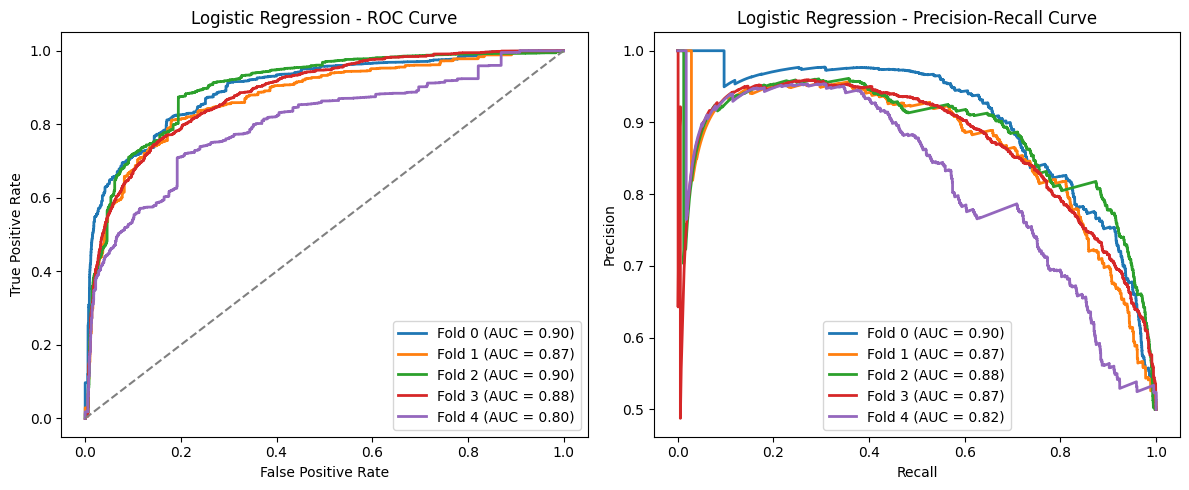

Running SVM


In [ ]:
run_modeling_pipeline_from_csv(fold_numbers=[0,1,2,3,4])

In [1]:
### SVM taking very long

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc
)
import numpy as np
from tqdm import tqdm  # <-- added tqdm

FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']
LABEL = ['Same_Complex']

def run_modeling_pipeline_from_csv(fold_numbers, label_col='Same_Complex'):
    """
    Trains Logistic Regression, SVM, and Random Forest across precomputed CSV folds
    and plots ROC + PR curves.

    Parameters:
        fold_numbers (List[int]): List of fold identifiers (e.g., [1, 2, 3, 4, 5]).
        label_col (str): Name of the label column in the CSV files.

    File format assumption:
        - For fold i:
            - X_y_train_i.csv
            - X_y_test_i.csv
        - Each CSV contains feature columns and a 'Label' column.
    """


    print("Starting logsitic regression, SVM and random forest")

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1)
    }

    model_results = pd.DataFrame()

    for model_name, model in tqdm(models.items(), desc="Model Loop"):  # <-- wrapped with tqdm
        print(f"Running {model_name}")
        plt.figure(figsize=(12, 5))

        roc = []
        pr = []

        # ROC Curve
        plt.subplot(1, 2, 1)
        for i in tqdm(fold_numbers, desc=f"ROC Folds ({model_name})"):  # <-- wrapped with tqdm
            data = pd.read_csv(f'balanced_group_stratified_fold_{i}.csv')
            data = data.copy()
            ALL = FEATURES + LABEL
            train_df = data[data['Test']==False][ALL].dropna()
            test_df = data[data['Test']==True][ALL].dropna()

            X_train = train_df[FEATURES]
            y_train = train_df[LABEL[0]]
            X_test = test_df[FEATURES]
            y_test = test_df[LABEL[0]]

            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)[:, 1]

            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            roc.append(roc_auc)
            plt.plot(fpr, tpr, lw=2, label=f"Fold {i} (AUC = {roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"{model_name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()

        # PR Curve
        plt.subplot(1, 2, 2)
        for i in tqdm(fold_numbers, desc=f"PR Folds ({model_name})"):  # <-- wrapped with tqdm
            data = pd.read_csv(f'balanced_group_stratified_fold_{i}.csv')
            ALL = FEATURES + LABEL
            train_df = data[data['Test']==False][ALL].dropna()
            test_df = data[data['Test']==True][ALL].dropna()

            X_train = train_df[FEATURES]
            y_train = train_df[LABEL[0]]
            X_test = test_df[FEATURES]
            y_test = test_df[LABEL[0]]

            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)[:, 1]

            precision, recall, _ = precision_recall_curve(y_test, y_score)
            pr_auc = auc(recall, precision)
            pr.append(pr_auc)
            plt.plot(recall, precision, lw=2, label=f"Fold {i} (AUC = {pr_auc:.2f})")

        model_results[f'{model_name}_AUROC_per_fold'] = roc
        model_results[f'{model_name}_AUPRC_per_fold'] = pr

        plt.title(f"{model_name} - Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{model_name}_all_features_cs_roc_pr_balanced_stratified_group.png", dpi=300)
        plt.show()

    display(model_results)

    model_results = model_results.reset_index()
    model_results.rename(columns={'index':'Fold'}, inplace=True)
    model_results.to_csv('all_features_cosine_similarity_model_results_balanced_group_stratified.csv', index=False)


Starting logsitic regression, SVM and random forest


Model Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Running Logistic Regression



ROC Folds (Logistic Regression): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

PR Folds (Logistic Regression): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


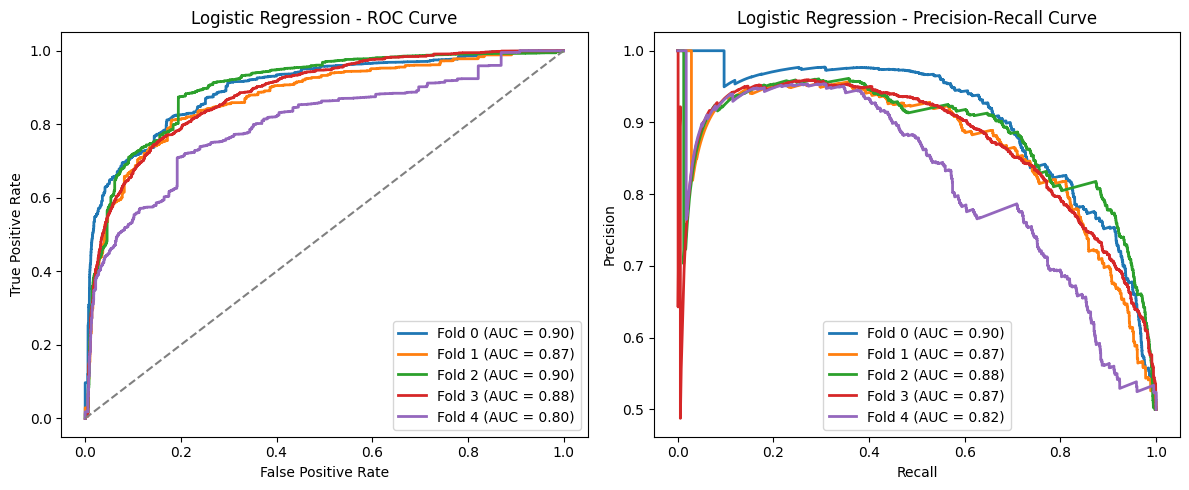

Model Loop:  50%|█████     | 1/2 [00:07<00:07,  7.68s/it]

Running Random Forest



ROC Folds (Random Forest): 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]

PR Folds (Random Forest): 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


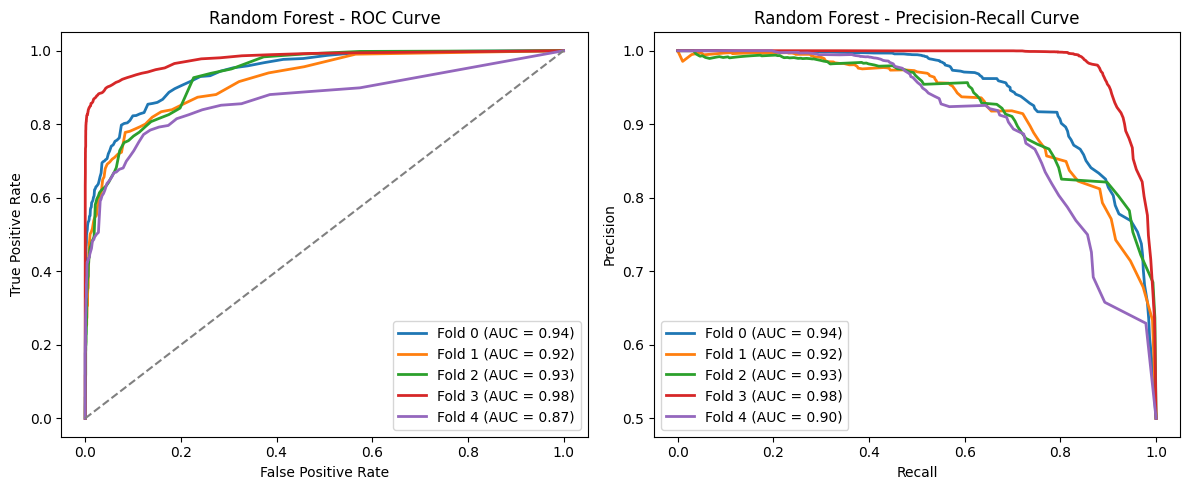

Model Loop: 100%|██████████| 2/2 [00:27<00:00, 13.95s/it]


,Logistic Regression_AUROC_per_fold,Logistic Regression_AUPRC_per_fold,Random Forest_AUROC_per_fold,Random Forest_AUPRC_per_fold
0,0.898074,0.904633,0.941895,0.944839
1,0.871551,0.868933,0.918908,0.922998
2,0.899753,0.883600,0.931410,0.927317
3,0.882364,0.867904,0.978258,0.982681
4,0.801399,0.816871,0.868715,0.904001


In [2]:
run_modeling_pipeline_from_csv(fold_numbers=[0,1,2,3,4])

In [6]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

def run_rfecv_across_folds(df, feature_cols, label_col, cv_folds, estimator=None,
                            scoring='roc_auc', min_features_to_select=1, step=1, verbose=1):
    """
    Runs RFECV within each fold, selects optimal features, evaluates performance.

    Parameters
    ----------
    df : pd.DataFrame
        Full dataset with features and label.
    feature_cols : list
        Names of columns to use as features.
    label_col : str
        Name of binary classification target.
    cv_folds : list
        List of (train_idx, test_idx) tuples (e.g., from stratified_group_split_balanced_per_fold).
    estimator : sklearn estimator
        Base model to use (e.g., LogisticRegression or ExtraTreesClassifier).
    scoring : str
        Scoring metric for RFECV (e.g., 'accuracy', 'roc_auc').
    min_features_to_select : int
        Minimum number of features to keep.
    step : int
        Number of features to remove at each step in RFECV.
    verbose : int
        Verbosity level (0 = silent).

    Returns
    -------
    dict
        Results for each fold: scores, selected features, rankings.
    """
    if estimator is None:
        estimator = LogisticRegression(max_iter=1000)

    results = []

    for i, (train_idx, test_idx) in enumerate(cv_folds):
        X_train = df.loc[train_idx, feature_cols]
        y_train = df.loc[train_idx, label_col]
        X_test = df.loc[test_idx, feature_cols]
        y_test = df.loc[test_idx, label_col]

        # Run RFECV on training set
        rfecv = RFECV(
            estimator=estimator,
            step=step,
            min_features_to_select=min_features_to_select,
            scoring=scoring,
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
            verbose=verbose
        )
        rfecv.fit(X_train, y_train)

        # Apply selected features to train/test
        selected_features = [feature for feature, keep in zip(feature_cols, rfecv.support_) if keep]
        X_train_reduced = X_train[selected_features]
        X_test_reduced = X_test[selected_features]

        # Fit final model on selected features
        model = estimator.__class__(**estimator.get_params())
        model.fit(X_train_reduced, y_train)
        y_pred = model.predict(X_test_reduced)
        y_prob = model.predict_proba(X_test_reduced)[:, 1] if hasattr(model, "predict_proba") else y_pred

        result = {
            'fold': i,
            'n_selected_features': len(selected_features),
            'selected_features': selected_features,
            'feature_ranking': dict(zip(feature_cols, rfecv.ranking_)),
            'test_accuracy': accuracy_score(y_test, y_pred),
            'test_auc': roc_auc_score(y_test, y_prob),
        }

        results.append(result)

        if verbose:
            print(f"\nFold {i+1}:")
            print(f"  Selected {len(selected_features)} features")
            print(f"  Accuracy: {result['test_accuracy']:.3f}, AUC: {result['test_auc']:.3f}")

    return results


In [27]:
FEATURES

['scGPT_bc_embeddings_Cosine_Similarity',
 'scGPT_pancancer_embeddings_Cosine_Similarity',
 'scGPT_lung_embeddings_Cosine_Similarity',
 'scGPT_heart_embeddings_Cosine_Similarity',
 'scGPT_brain_embeddings_Cosine_Similarity',
 'scGPT_kidney_embeddings_Cosine_Similarity',
 'scGPT_human_embeddings_Cosine_Similarity',
 'GF-6L30M_HUMANemb_Cosine_Similarity',
 'GF-20L95M_HUMANemb_Cosine_Similarity',
 'GF-12L95M_HUMANemb_Cosine_Similarity',
 'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
 'GF-12L30M_HUMANemb_Cosine_Similarity',
 'Correlation']

In [28]:
prepared_df = pd.read_csv('prepared_df.csv')

/tmp/ipykernel_97891/103268092.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  prepared_df = pd.read_csv('prepared_df.csv')


In [29]:
resultsLinSVC = run_rfecv_across_folds(
    df=prepared_df,
    feature_cols=FEATURES,
    label_col='Same_Complex',
    cv_folds=folds,
    estimator=LinearSVC(max_iter=10000, verbose=0, random_state=42),
    scoring='average_precision',
    verbose=1
)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting 

In [30]:
resultsLinSVC_rocauc = run_rfecv_across_folds(
    df=prepared_df,
    feature_cols=FEATURES,
    label_col='Same_Complex',
    cv_folds=folds,
    estimator=LinearSVC(max_iter=10000, verbose=0, random_state=42),
    scoring='roc_auc',
    verbose=1
)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting 

In [31]:
resultsSGD = run_rfecv_across_folds(
    df=prepared_df,
    feature_cols=FEATURES,
    label_col='Same_Complex',
    cv_folds=folds,
    estimator=SGDClassifier(loss='log_loss', max_iter=10000, random_state=42),
    scoring='average_precision',
    verbose=1
)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting 

In [32]:
resultsSGD_roc_auc = run_rfecv_across_folds(
    df=prepared_df,
    feature_cols=FEATURES,
    label_col='Same_Complex',
    cv_folds=folds,
    estimator=SGDClassifier(loss='log_loss', max_iter=10000, random_state=42),
    scoring='roc_auc',
    verbose=1
)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting 

In [37]:
results = run_rfecv_across_folds(
    df=prepared_df,
    feature_cols=FEATURES,
    label_col='Same_Complex',
    cv_folds=folds,
    estimator=RandomForestClassifier(n_estimators=100, n_jobs=-1),
    scoring='roc_auc',
    verbose=1
)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting 

In [67]:
results

[{'fold': 0,
  'n_selected_features': 12,
  'selected_features': ['scGPT_bc_embeddings_Cosine_Similarity',
   'scGPT_pancancer_embeddings_Cosine_Similarity',
   'scGPT_lung_embeddings_Cosine_Similarity',
   'scGPT_heart_embeddings_Cosine_Similarity',
   'scGPT_brain_embeddings_Cosine_Similarity',
   'scGPT_kidney_embeddings_Cosine_Similarity',
   'scGPT_human_embeddings_Cosine_Similarity',
   'GF-6L30M_HUMANemb_Cosine_Similarity',
   'GF-20L95M_HUMANemb_Cosine_Similarity',
   'GF-12L95M_HUMANemb_Cosine_Similarity',
   'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
   'GF-12L30M_HUMANemb_Cosine_Similarity'],
  'feature_ranking': {'scGPT_bc_embeddings_Cosine_Similarity': 1,
   'scGPT_pancancer_embeddings_Cosine_Similarity': 1,
   'scGPT_lung_embeddings_Cosine_Similarity': 1,
   'scGPT_heart_embeddings_Cosine_Similarity': 1,
   'scGPT_brain_embeddings_Cosine_Similarity': 1,
   'scGPT_kidney_embeddings_Cosine_Similarity': 1,
   'scGPT_human_embeddings_Cosine_Similarity': 1,
   'GF-6

In [38]:
results2 = run_rfecv_across_folds(
    df=prepared_df,
    feature_cols=FEATURES,
    label_col='Same_Complex',
    cv_folds=folds,
    estimator=RandomForestClassifier(n_estimators=100, n_jobs=-1),
    scoring='average_precision',
    verbose=1
)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting 

In [76]:
results2

[{'fold': 0,
  'n_selected_features': 12,
  'selected_features': ['scGPT_bc_embeddings_Cosine_Similarity',
   'scGPT_pancancer_embeddings_Cosine_Similarity',
   'scGPT_lung_embeddings_Cosine_Similarity',
   'scGPT_heart_embeddings_Cosine_Similarity',
   'scGPT_brain_embeddings_Cosine_Similarity',
   'scGPT_kidney_embeddings_Cosine_Similarity',
   'scGPT_human_embeddings_Cosine_Similarity',
   'GF-6L30M_HUMANemb_Cosine_Similarity',
   'GF-20L95M_HUMANemb_Cosine_Similarity',
   'GF-12L95M_HUMANemb_Cosine_Similarity',
   'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
   'GF-12L30M_HUMANemb_Cosine_Similarity'],
  'feature_ranking': {'scGPT_bc_embeddings_Cosine_Similarity': 1,
   'scGPT_pancancer_embeddings_Cosine_Similarity': 1,
   'scGPT_lung_embeddings_Cosine_Similarity': 1,
   'scGPT_heart_embeddings_Cosine_Similarity': 1,
   'scGPT_brain_embeddings_Cosine_Similarity': 1,
   'scGPT_kidney_embeddings_Cosine_Similarity': 1,
   'scGPT_human_embeddings_Cosine_Similarity': 1,
   'GF-6

In [73]:
from sklearn.metrics import get_scorer_names
get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'd2_absolute_error_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_max_error',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 're

In [39]:
results_lg_auroc = run_rfecv_across_folds(
    df=prepared_df,
    feature_cols=FEATURES,
    label_col='Same_Complex',
    cv_folds=folds,
    scoring='roc_auc',
    verbose=1
)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting 

In [40]:
results_lg_auprc = run_rfecv_across_folds(
    df=prepared_df,
    feature_cols=FEATURES,
    label_col='Same_Complex',
    cv_folds=folds,
    scoring='average_precision',
    verbose=1
)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting 

In [80]:
results_lg_auroc

[{'fold': 0,
  'n_selected_features': 11,
  'selected_features': ['scGPT_bc_embeddings_Cosine_Similarity',
   'scGPT_pancancer_embeddings_Cosine_Similarity',
   'scGPT_heart_embeddings_Cosine_Similarity',
   'scGPT_brain_embeddings_Cosine_Similarity',
   'scGPT_kidney_embeddings_Cosine_Similarity',
   'scGPT_human_embeddings_Cosine_Similarity',
   'GF-6L30M_HUMANemb_Cosine_Similarity',
   'GF-20L95M_HUMANemb_Cosine_Similarity',
   'GF-12L95M_HUMANemb_Cosine_Similarity',
   'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
   'GF-12L30M_HUMANemb_Cosine_Similarity'],
  'feature_ranking': {'scGPT_bc_embeddings_Cosine_Similarity': 1,
   'scGPT_pancancer_embeddings_Cosine_Similarity': 1,
   'scGPT_lung_embeddings_Cosine_Similarity': 2,
   'scGPT_heart_embeddings_Cosine_Similarity': 1,
   'scGPT_brain_embeddings_Cosine_Similarity': 1,
   'scGPT_kidney_embeddings_Cosine_Similarity': 1,
   'scGPT_human_embeddings_Cosine_Similarity': 1,
   'GF-6L30M_HUMANemb_Cosine_Similarity': 1,
   'GF-20

In [95]:
results_list = [results, results2, results_lg_auroc, results_lg_auprc]

In [94]:
results_list

[[{'fold': 0,
   'n_selected_features': 12,
   'selected_features': ['scGPT_bc_embeddings_Cosine_Similarity',
    'scGPT_pancancer_embeddings_Cosine_Similarity',
    'scGPT_lung_embeddings_Cosine_Similarity',
    'scGPT_heart_embeddings_Cosine_Similarity',
    'scGPT_brain_embeddings_Cosine_Similarity',
    'scGPT_kidney_embeddings_Cosine_Similarity',
    'scGPT_human_embeddings_Cosine_Similarity',
    'GF-6L30M_HUMANemb_Cosine_Similarity',
    'GF-20L95M_HUMANemb_Cosine_Similarity',
    'GF-12L95M_HUMANemb_Cosine_Similarity',
    'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
    'GF-12L30M_HUMANemb_Cosine_Similarity'],
   'feature_ranking': {'scGPT_bc_embeddings_Cosine_Similarity': 1,
    'scGPT_pancancer_embeddings_Cosine_Similarity': 1,
    'scGPT_lung_embeddings_Cosine_Similarity': 1,
    'scGPT_heart_embeddings_Cosine_Similarity': 1,
    'scGPT_brain_embeddings_Cosine_Similarity': 1,
    'scGPT_kidney_embeddings_Cosine_Similarity': 1,
    'scGPT_human_embeddings_Cosine_Sim

In [33]:
def plot_feature_exclusion_frequency_multiple_results(results_list, all_features, figsize=(8,10), top_n=None):
    """
    Plots how often each feature was excluded across multiple RFECV results lists.

    Parameters
    ----------
    results_list : list of list of dict
        Each inner list is a list of RFECV results from one run (e.g., different models).
    all_features : list
        Complete list of feature names.
    figsize : tuple
        Size of the matplotlib figure.
    top_n : int or None
        Number of top excluded features to show. If None, show all.

    Returns
    -------
    None
    """
    from collections import Counter
    import matplotlib.pyplot as plt
    import pandas as pd

    total_folds = sum(len(results) for results in results_list)

    # Count how many times each feature was selected across all result sets
    selected_counts = Counter()
    for results in results_list:
        for res in results:
            selected_counts.update(res['selected_features'])

    # Compute exclusion counts
    exclusion_counts = {feat: total_folds - selected_counts.get(feat, 0) for feat in all_features}

    # Create DataFrame
    exclusion_df = pd.DataFrame.from_dict(exclusion_counts, orient='index', columns=['times_excluded'])
    exclusion_df = exclusion_df.sort_values(by='times_excluded', ascending=False)

    if top_n:
        exclusion_df = exclusion_df.head(top_n)
    display(exclusion_df['times_excluded'])
    # Plot
    plt.figure(figsize=figsize)
    exclusion_df['times_excluded'].plot(kind='bar')
    plt.title(f'Feature Exclusion Frequency Across {total_folds} Folds')
    plt.ylabel('Number of Folds Excluded')
    plt.xlabel('Feature')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


In [34]:
FEATURES

['scGPT_bc_embeddings_Cosine_Similarity',
 'scGPT_pancancer_embeddings_Cosine_Similarity',
 'scGPT_lung_embeddings_Cosine_Similarity',
 'scGPT_heart_embeddings_Cosine_Similarity',
 'scGPT_brain_embeddings_Cosine_Similarity',
 'scGPT_kidney_embeddings_Cosine_Similarity',
 'scGPT_human_embeddings_Cosine_Similarity',
 'GF-6L30M_HUMANemb_Cosine_Similarity',
 'GF-20L95M_HUMANemb_Cosine_Similarity',
 'GF-12L95M_HUMANemb_Cosine_Similarity',
 'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
 'GF-12L30M_HUMANemb_Cosine_Similarity',
 'Correlation']

In [41]:
results_list = [results, results2, results_lg_auroc, results_lg_auprc, resultsLinSVC, resultsLinSVC_rocauc, resultsSGD, resultsSGD_roc_auc]

Correlation                                           17
scGPT_heart_embeddings_Cosine_Similarity               6
scGPT_lung_embeddings_Cosine_Similarity                5
GF-20L95M_HUMANemb_Cosine_Similarity                   5
GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity     5
scGPT_pancancer_embeddings_Cosine_Similarity           3
scGPT_kidney_embeddings_Cosine_Similarity              3
GF-12L95M_HUMANemb_Cosine_Similarity                   2
scGPT_bc_embeddings_Cosine_Similarity                  0
scGPT_brain_embeddings_Cosine_Similarity               0
scGPT_human_embeddings_Cosine_Similarity               0
GF-6L30M_HUMANemb_Cosine_Similarity                    0
GF-12L30M_HUMANemb_Cosine_Similarity                   0
Name: times_excluded, dtype: int64

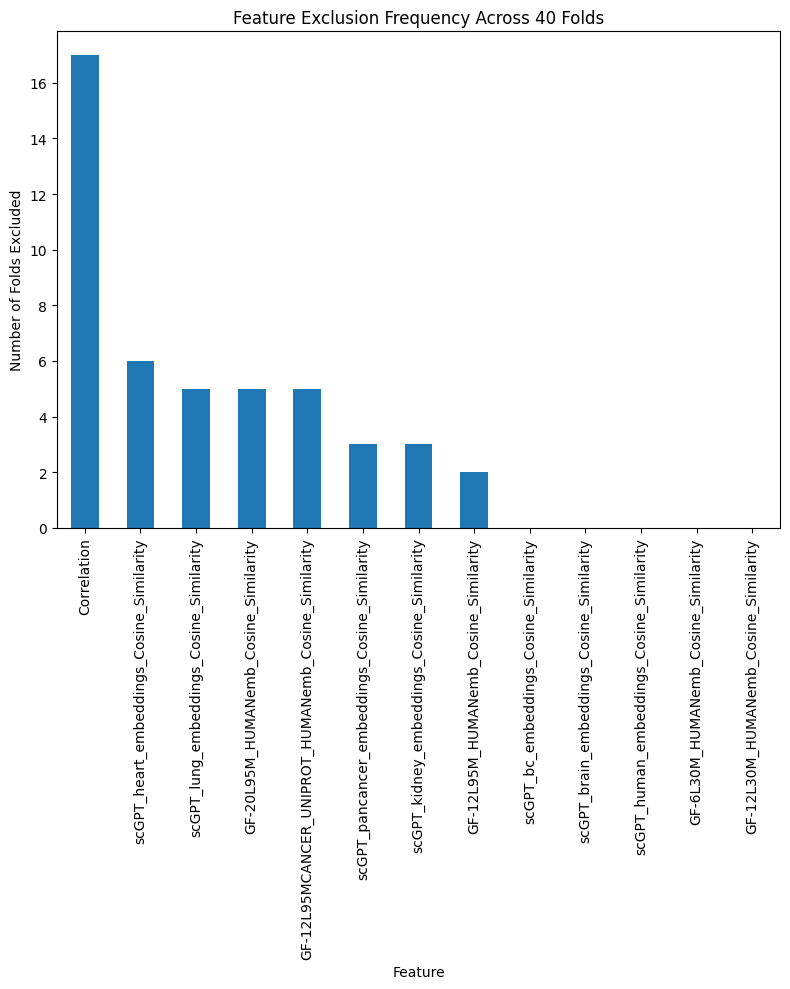

In [42]:
plot_feature_exclusion_frequency_multiple_results(results_list, all_features = FEATURES, top_n = 20)

GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity    3
scGPT_lung_embeddings_Cosine_Similarity               2
scGPT_heart_embeddings_Cosine_Similarity              2
GF-20L95M_HUMANemb_Cosine_Similarity                  2
Correlation                                           2
scGPT_pancancer_embeddings_Cosine_Similarity          1
scGPT_kidney_embeddings_Cosine_Similarity             1
scGPT_bc_embeddings_Cosine_Similarity                 0
scGPT_brain_embeddings_Cosine_Similarity              0
scGPT_human_embeddings_Cosine_Similarity              0
GF-6L30M_HUMANemb_Cosine_Similarity                   0
GF-12L95M_HUMANemb_Cosine_Similarity                  0
GF-12L30M_HUMANemb_Cosine_Similarity                  0
Name: times_excluded, dtype: int64

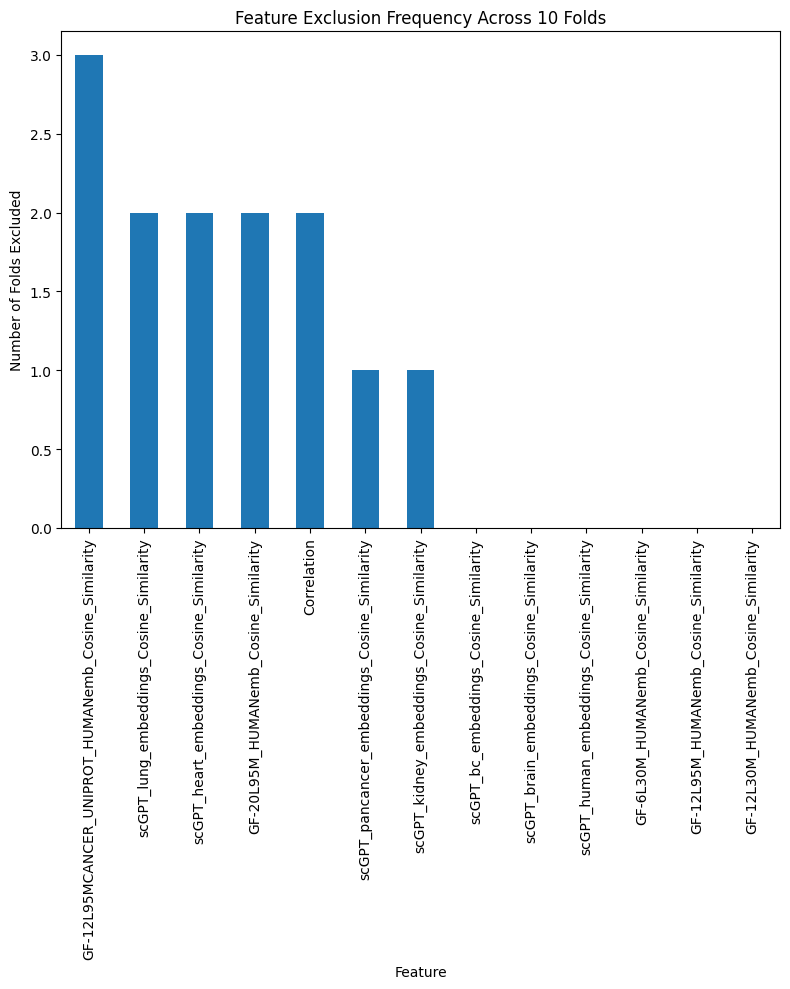

In [35]:

plot_feature_exclusion_frequency_multiple_results([resultsLinSVC+resultsLinSVC_rocauc], all_features = FEATURES, top_n = 20)

Correlation                                           2
scGPT_lung_embeddings_Cosine_Similarity               1
scGPT_bc_embeddings_Cosine_Similarity                 0
scGPT_pancancer_embeddings_Cosine_Similarity          0
scGPT_heart_embeddings_Cosine_Similarity              0
scGPT_brain_embeddings_Cosine_Similarity              0
scGPT_kidney_embeddings_Cosine_Similarity             0
scGPT_human_embeddings_Cosine_Similarity              0
GF-6L30M_HUMANemb_Cosine_Similarity                   0
GF-20L95M_HUMANemb_Cosine_Similarity                  0
GF-12L95M_HUMANemb_Cosine_Similarity                  0
GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity    0
GF-12L30M_HUMANemb_Cosine_Similarity                  0
Name: times_excluded, dtype: int64

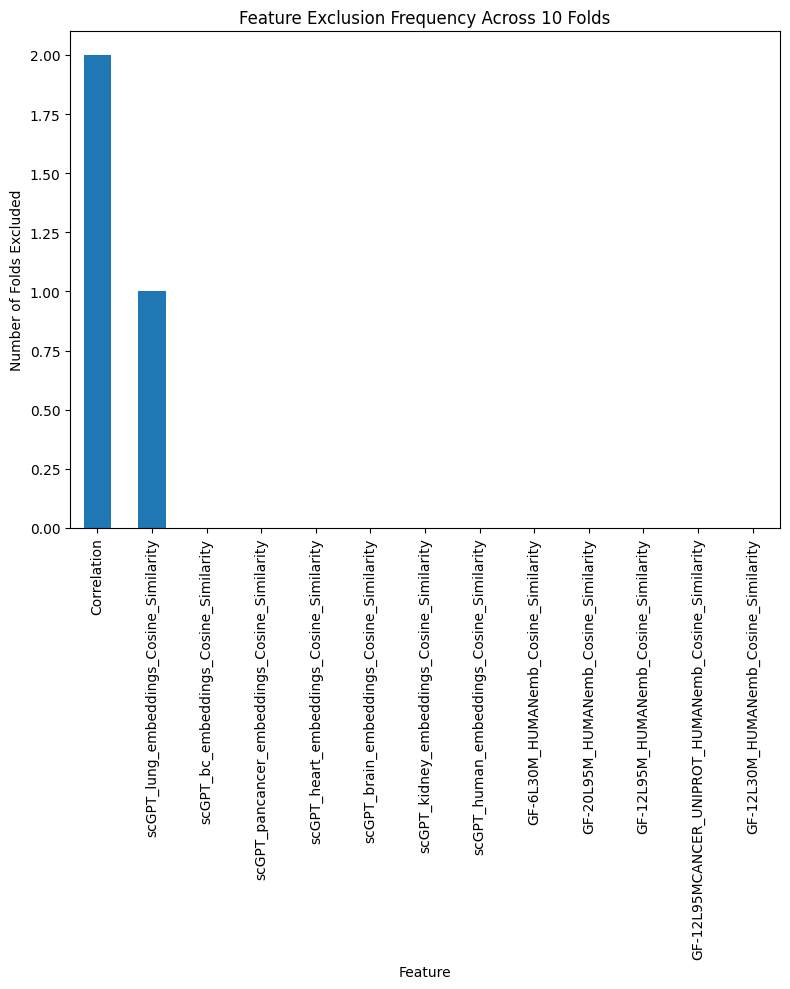

In [36]:
plot_feature_exclusion_frequency_multiple_results([resultsSGD + resultsSGD_roc_auc], all_features = FEATURES, top_n = 20)

In [100]:
FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']

Correlation                                           6
scGPT_heart_embeddings_Cosine_Similarity              2
scGPT_lung_embeddings_Cosine_Similarity               1
GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity    1
scGPT_bc_embeddings_Cosine_Similarity                 0
scGPT_pancancer_embeddings_Cosine_Similarity          0
scGPT_brain_embeddings_Cosine_Similarity              0
scGPT_kidney_embeddings_Cosine_Similarity             0
scGPT_human_embeddings_Cosine_Similarity              0
GF-6L30M_HUMANemb_Cosine_Similarity                   0
GF-20L95M_HUMANemb_Cosine_Similarity                  0
GF-12L95M_HUMANemb_Cosine_Similarity                  0
GF-12L30M_HUMANemb_Cosine_Similarity                  0
Name: times_excluded, dtype: int64

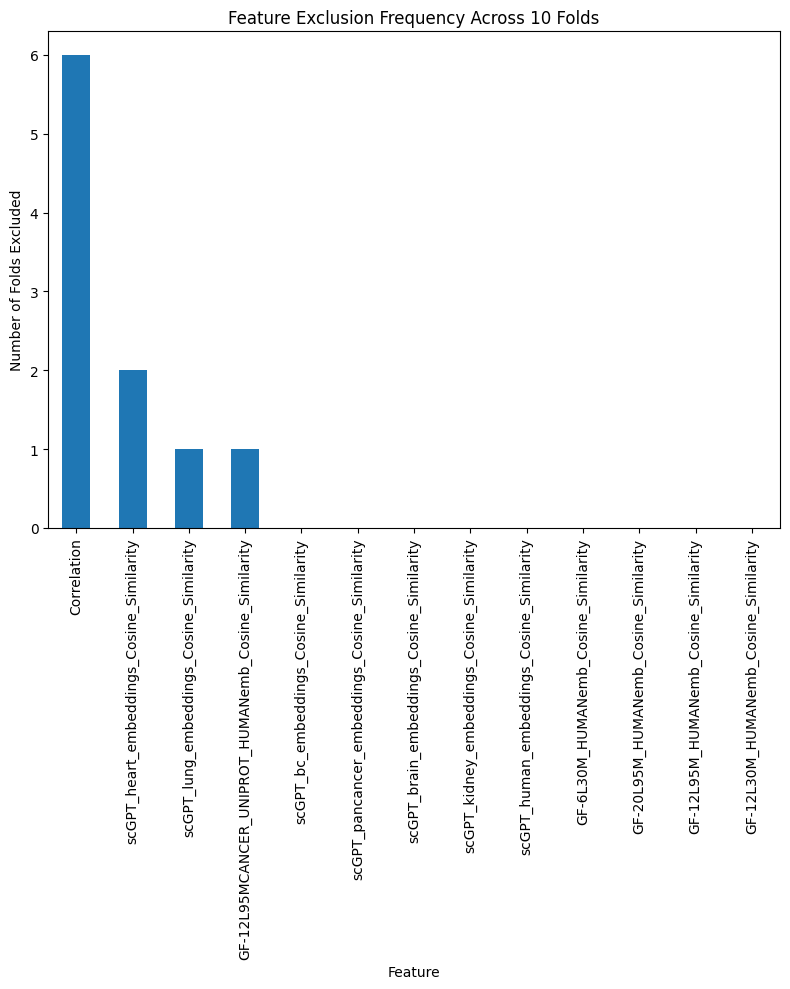

In [102]:
results_list = [results, results2]
plot_feature_exclusion_frequency_multiple_results(results_list, all_features=FEATURES, top_n=20)

Correlation                                           6
scGPT_heart_embeddings_Cosine_Similarity              4
GF-20L95M_HUMANemb_Cosine_Similarity                  3
scGPT_pancancer_embeddings_Cosine_Similarity          2
scGPT_lung_embeddings_Cosine_Similarity               2
scGPT_kidney_embeddings_Cosine_Similarity             2
GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity    2
scGPT_bc_embeddings_Cosine_Similarity                 0
scGPT_brain_embeddings_Cosine_Similarity              0
scGPT_human_embeddings_Cosine_Similarity              0
GF-6L30M_HUMANemb_Cosine_Similarity                   0
GF-12L95M_HUMANemb_Cosine_Similarity                  0
GF-12L30M_HUMANemb_Cosine_Similarity                  0
Name: times_excluded, dtype: int64

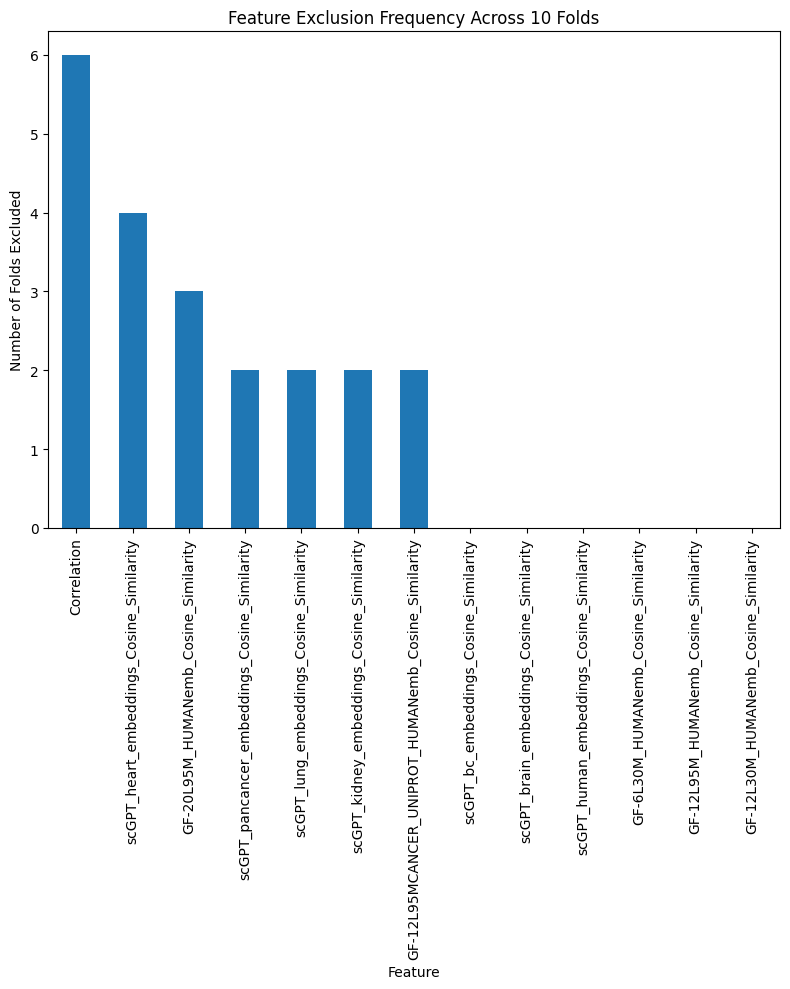

In [103]:
results_list = [results_lg_auroc, results_lg_auprc]
plot_feature_exclusion_frequency_multiple_results(results_list, all_features=FEATURES, top_n=20)

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc
)
import numpy as np
from tqdm import tqdm  # <-- added tqdm

FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity']
LABEL = ['Same_Complex']

def run_modeling_pipeline_from_csv(fold_numbers, label_col='Same_Complex'):
    """
    Trains Logistic Regression, SVM, and Random Forest across precomputed CSV folds
    and plots ROC + PR curves.

    Parameters:
        fold_numbers (List[int]): List of fold identifiers (e.g., [1, 2, 3, 4, 5]).
        label_col (str): Name of the label column in the CSV files.

    File format assumption:
        - For fold i:
            - X_y_train_i.csv
            - X_y_test_i.csv
        - Each CSV contains feature columns and a 'Label' column.
    """


    print("Starting logsitic regression, SVM and random forest")

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1)
    }

    model_results = pd.DataFrame()

    for model_name, model in tqdm(models.items(), desc="Model Loop"):  # <-- wrapped with tqdm
        print(f"Running {model_name}")
        plt.figure(figsize=(12, 5))

        roc = []
        pr = []

        # ROC Curve
        plt.subplot(1, 2, 1)
        for i in tqdm(fold_numbers, desc=f"ROC Folds ({model_name})"):  # <-- wrapped with tqdm
            data = pd.read_csv(f'balanced_group_stratified_fold_{i}.csv')
            data = data.copy()
            ALL = FEATURES + LABEL
            train_df = data[data['Test']==False][ALL].dropna()
            test_df = data[data['Test']==True][ALL].dropna()

            X_train = train_df[FEATURES]
            y_train = train_df[LABEL[0]]
            X_test = test_df[FEATURES]
            y_test = test_df[LABEL[0]]

            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)[:, 1]

            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            roc.append(roc_auc)
            plt.plot(fpr, tpr, lw=2, label=f"Fold {i} (AUC = {roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"{model_name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()

        # PR Curve
        plt.subplot(1, 2, 2)
        for i in tqdm(fold_numbers, desc=f"PR Folds ({model_name})"):  # <-- wrapped with tqdm
            data = pd.read_csv(f'balanced_group_stratified_fold_{i}.csv')
            ALL = FEATURES + LABEL
            train_df = data[data['Test']==False][ALL].dropna()
            test_df = data[data['Test']==True][ALL].dropna()

            X_train = train_df[FEATURES]
            y_train = train_df[LABEL[0]]
            X_test = test_df[FEATURES]
            y_test = test_df[LABEL[0]]

            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)[:, 1]

            precision, recall, _ = precision_recall_curve(y_test, y_score)
            pr_auc = auc(recall, precision)
            pr.append(pr_auc)
            plt.plot(recall, precision, lw=2, label=f"Fold {i} (AUC = {pr_auc:.2f})")

        model_results[f'{model_name}_AUROC_per_fold'] = roc
        model_results[f'{model_name}_AUPRC_per_fold'] = pr

        plt.title(f"{model_name} - Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{model_name}_all_features_cs_roc_pr_balanced_stratified_group_feat_select.png", dpi=300)
        plt.show()

    display(model_results)

    model_results = model_results.reset_index()
    model_results.rename(columns={'index':'Fold'}, inplace=True)
    model_results.to_csv('all_features_cosine_similarity_model_results_balanced_group_stratified_feat_select.csv', index=False)


Starting logsitic regression, SVM and random forest


Model Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Running Logistic Regression



ROC Folds (Logistic Regression): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

PR Folds (Logistic Regression): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


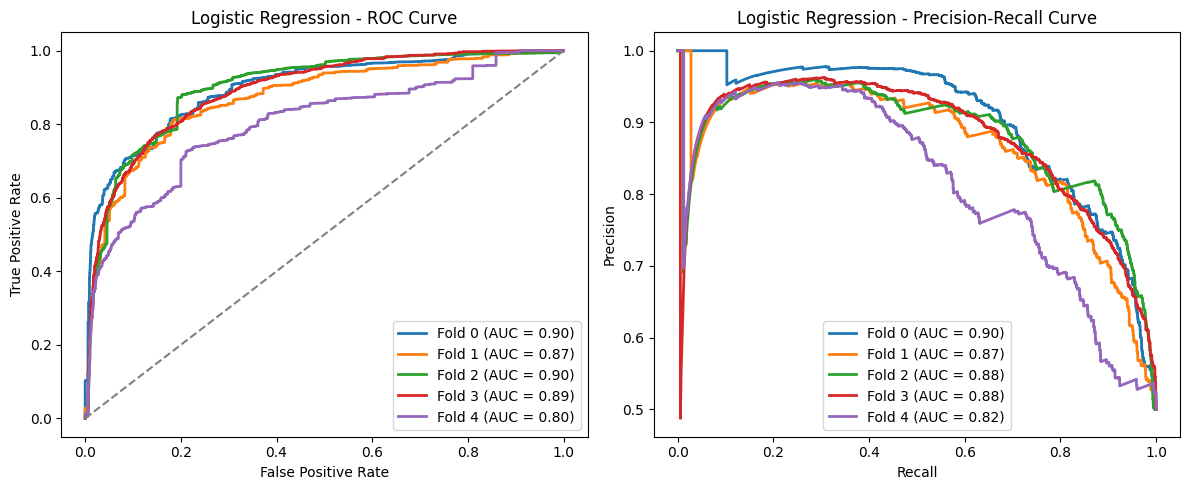

Model Loop:  50%|█████     | 1/2 [00:07<00:07,  7.73s/it]

Running Random Forest



ROC Folds (Random Forest): 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]

PR Folds (Random Forest): 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


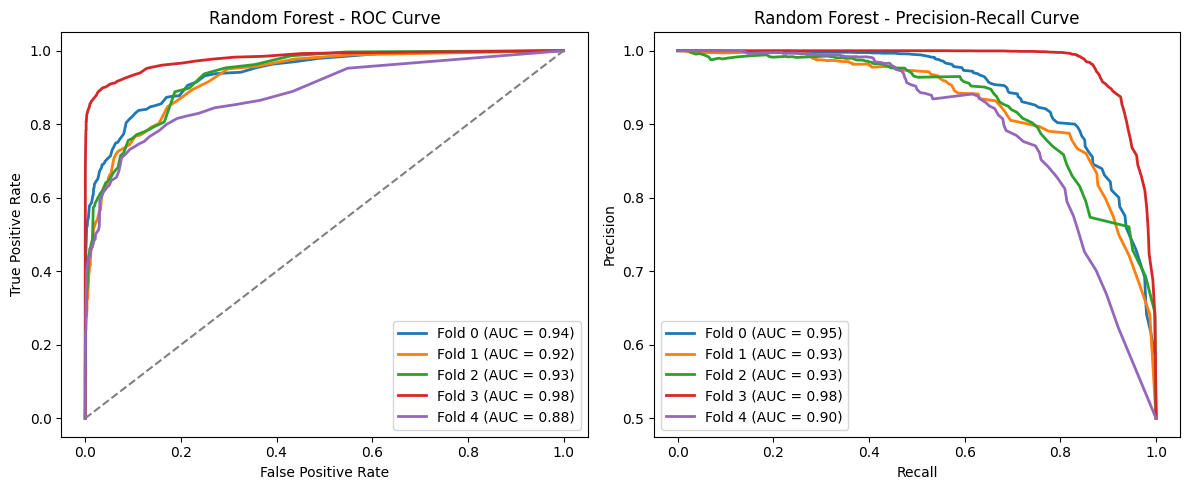

Model Loop: 100%|██████████| 2/2 [00:27<00:00, 13.79s/it]


,Logistic Regression_AUROC_per_fold,Logistic Regression_AUPRC_per_fold,Random Forest_AUROC_per_fold,Random Forest_AUPRC_per_fold
0,0.897954,0.904853,0.937285,0.946064
1,0.871491,0.868542,0.924640,0.928879
2,0.899296,0.882593,0.930825,0.927185
3,0.892043,0.877987,0.978512,0.983376
4,0.802321,0.816077,0.884366,0.899775


In [88]:
run_modeling_pipeline_from_csv(fold_numbers=[0,1,2,3,4])

In [91]:
pd.read_csv('all_features_cosine_similarity_model_results_balanced_group_stratified_feat_select.csv').describe()

,Fold,Logistic Regression_AUROC_per_fold,Logistic Regression_AUPRC_per_fold,Random Forest_AUROC_per_fold,Random Forest_AUPRC_per_fold
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,2.000000,0.872621,0.870010,0.931126,0.937056
std,1.581139,0.040847,0.032965,0.033586,0.030744
min,0.000000,0.802321,0.816077,0.884366,0.899775
25%,1.000000,0.871491,0.868542,0.924640,0.927185
50%,2.000000,0.892043,0.877987,0.930825,0.928879
75%,3.000000,0.897954,0.882593,0.937285,0.946064
max,4.000000,0.899296,0.904853,0.978512,0.983376


In [90]:
pd.read_csv('all_features_cosine_similarity_model_results_balanced_group_stratified.csv').describe()

,Fold,Logistic Regression_AUROC_per_fold,Logistic Regression_AUPRC_per_fold,Random Forest_AUROC_per_fold,Random Forest_AUPRC_per_fold
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,2.000000,0.870628,0.868388,0.927837,0.936367
std,1.581139,0.040413,0.032402,0.039774,0.029686
min,0.000000,0.801399,0.816871,0.868715,0.904001
25%,1.000000,0.871551,0.867904,0.918908,0.922998
50%,2.000000,0.882364,0.868933,0.931410,0.927317
75%,3.000000,0.898074,0.883600,0.941895,0.944839
max,4.000000,0.899753,0.904633,0.978258,0.982681


In [108]:
pd.read_csv('all_features_cosine_similarity_model_results_balanced_group_stratified_feat_select_SMALL.csv').describe()

,Fold,Logistic Regression_AUROC_per_fold,Logistic Regression_AUPRC_per_fold,Random Forest_AUROC_per_fold,Random Forest_AUPRC_per_fold
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,2.000000,0.880546,0.877345,0.924871,0.934143
std,1.581139,0.037573,0.030820,0.038900,0.032089
min,0.000000,0.817901,0.827714,0.871436,0.896162
25%,1.000000,0.873625,0.870302,0.906842,0.916627
50%,2.000000,0.900086,0.885256,0.932122,0.931033
75%,3.000000,0.901011,0.897539,0.937506,0.945524
max,4.000000,0.910108,0.905913,0.976450,0.981370


In [105]:
SMALL_FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',                 
'scGPT_brain_embeddings_Cosine_Similarity',             
'scGPT_human_embeddings_Cosine_Similarity',              
'GF-6L30M_HUMANemb_Cosine_Similarity',                   
'GF-12L95M_HUMANemb_Cosine_Similarity',                  
'GF-12L30M_HUMANemb_Cosine_Similarity']        

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc
)
import numpy as np
from tqdm import tqdm  # <-- added tqdm

FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity']
LABEL = ['Same_Complex']

def run_modeling_pipeline_from_csv(fold_numbers, label_col='Same_Complex'):
    """
    Trains Logistic Regression, SVM, and Random Forest across precomputed CSV folds
    and plots ROC + PR curves.

    Parameters:
        fold_numbers (List[int]): List of fold identifiers (e.g., [1, 2, 3, 4, 5]).
        label_col (str): Name of the label column in the CSV files.

    File format assumption:
        - For fold i:
            - X_y_train_i.csv
            - X_y_test_i.csv
        - Each CSV contains feature columns and a 'Label' column.
    """


    print("Starting logsitic regression, SVM and random forest")

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1)
    }

    model_results = pd.DataFrame()

    for model_name, model in tqdm(models.items(), desc="Model Loop"):  # <-- wrapped with tqdm
        print(f"Running {model_name}")
        plt.figure(figsize=(12, 5))

        roc = []
        pr = []

        # ROC Curve
        plt.subplot(1, 2, 1)
        for i in tqdm(fold_numbers, desc=f"ROC Folds ({model_name})"):  # <-- wrapped with tqdm
            data = pd.read_csv(f'balanced_group_stratified_fold_{i}.csv')
            data = data.copy()
            ALL = SMALL_FEATURES + LABEL
            train_df = data[data['Test']==False][ALL].dropna()
            test_df = data[data['Test']==True][ALL].dropna()

            X_train = train_df[SMALL_FEATURES]
            y_train = train_df[LABEL[0]]
            X_test = test_df[SMALL_FEATURES]
            y_test = test_df[LABEL[0]]

            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)[:, 1]

            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            roc.append(roc_auc)
            plt.plot(fpr, tpr, lw=2, label=f"Fold {i} (AUC = {roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"{model_name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()

        # PR Curve
        plt.subplot(1, 2, 2)
        for i in tqdm(fold_numbers, desc=f"PR Folds ({model_name})"):  # <-- wrapped with tqdm
            data = pd.read_csv(f'balanced_group_stratified_fold_{i}.csv')
            ALL = SMALL_FEATURES + LABEL
            train_df = data[data['Test']==False][ALL].dropna()
            test_df = data[data['Test']==True][ALL].dropna()

            X_train = train_df[SMALL_FEATURES]
            y_train = train_df[LABEL[0]]
            X_test = test_df[SMALL_FEATURES]
            y_test = test_df[LABEL[0]]

            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)[:, 1]

            precision, recall, _ = precision_recall_curve(y_test, y_score)
            pr_auc = auc(recall, precision)
            pr.append(pr_auc)
            plt.plot(recall, precision, lw=2, label=f"Fold {i} (AUC = {pr_auc:.2f})")

        model_results[f'{model_name}_AUROC_per_fold'] = roc
        model_results[f'{model_name}_AUPRC_per_fold'] = pr

        plt.title(f"{model_name} - Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{model_name}_all_features_cs_roc_pr_balanced_stratified_group_feat_select_SMALL.png", dpi=300)
        plt.show()

    display(model_results)

    model_results = model_results.reset_index()
    model_results.rename(columns={'index':'Fold'}, inplace=True)
    model_results.to_csv('all_features_cosine_similarity_model_results_balanced_group_stratified_feat_select_SMALL.csv', index=False)


Starting logsitic regression, SVM and random forest


Model Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Running Logistic Regression



ROC Folds (Logistic Regression): 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]

PR Folds (Logistic Regression): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


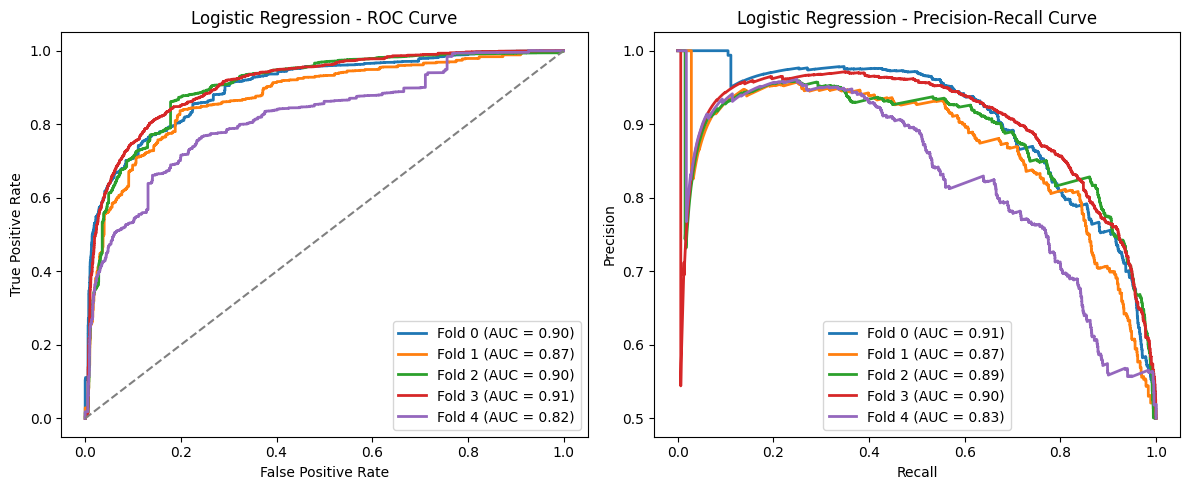

Model Loop:  50%|█████     | 1/2 [00:07<00:07,  7.54s/it]

Running Random Forest



ROC Folds (Random Forest): 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]

PR Folds (Random Forest): 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


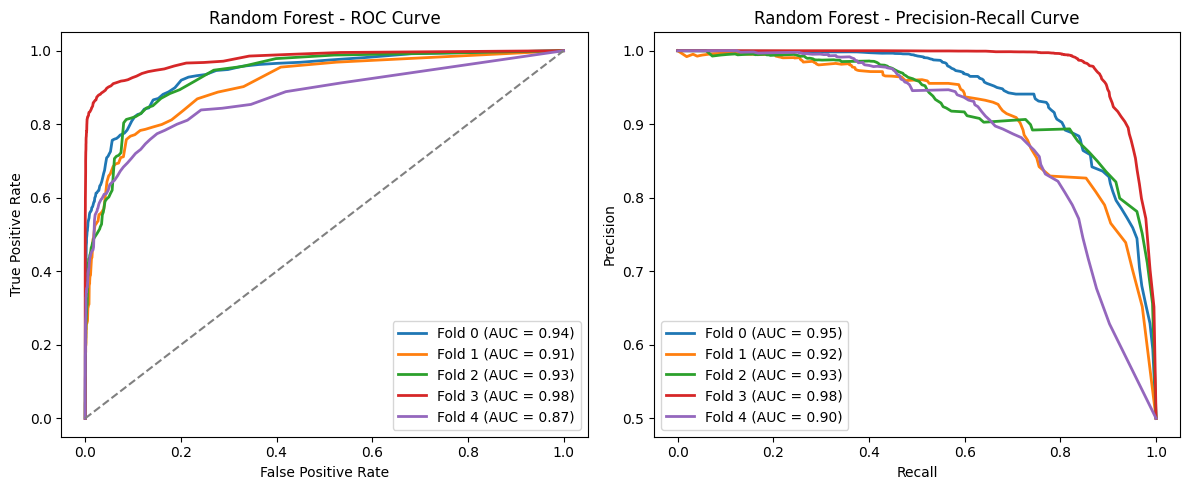

Model Loop: 100%|██████████| 2/2 [00:23<00:00, 11.80s/it]


,Logistic Regression_AUROC_per_fold,Logistic Regression_AUPRC_per_fold,Random Forest_AUROC_per_fold,Random Forest_AUPRC_per_fold
0,0.900086,0.905913,0.937506,0.945524
1,0.873625,0.870302,0.906842,0.916627
2,0.901011,0.885256,0.932122,0.931033
3,0.910108,0.897539,0.976450,0.981370
4,0.817901,0.827714,0.871436,0.896162


In [107]:
run_modeling_pipeline_from_csv(fold_numbers=[0,1,2,3,4])

In [1]:
SMALL_FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',
 'scGPT_brain_embeddings_Cosine_Similarity',
 'scGPT_human_embeddings_Cosine_Similarity',
 'GF-6L30M_HUMANemb_Cosine_Similarity',
 'GF-12L95M_HUMANemb_Cosine_Similarity',
 'GF-12L30M_HUMANemb_Cosine_Similarity']


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc
)
import numpy as np
from tqdm import tqdm  # <-- added tqdm

FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity']
LABEL = ['Same_Complex']

def run_modeling_pipeline_from_csv(fold_numbers, label_col='Same_Complex'):
    """
    Trains Logistic Regression, SVM, and Random Forest across precomputed CSV folds
    and plots ROC + PR curves.

    Parameters:
        fold_numbers (List[int]): List of fold identifiers (e.g., [1, 2, 3, 4, 5]).
        label_col (str): Name of the label column in the CSV files.

    File format assumption:
        - For fold i:
            - X_y_train_i.csv
            - X_y_test_i.csv
        - Each CSV contains feature columns and a 'Label' column.
    """


    print("Starting logsitic regression, SVM and random forest")

    models = {
        "SVM": SVC(probability=True),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1)
    }

    model_results = pd.DataFrame()

    for model_name, model in tqdm(models.items(), desc="Model Loop"):  # <-- wrapped with tqdm
        print(f"Running {model_name}")
        plt.figure(figsize=(12, 5))

        roc = []
        pr = []

        # ROC Curve
        plt.subplot(1, 2, 1)
        for i in tqdm(fold_numbers, desc=f"ROC Folds ({model_name})"):  # <-- wrapped with tqdm
            data = pd.read_csv(f'balanced_group_stratified_fold_{i}.csv')
            data = data.copy()
            ALL = SMALL_FEATURES + LABEL
            train_df = data[data['Test']==False][ALL].dropna()
            test_df = data[data['Test']==True][ALL].dropna()

            X_train = train_df[SMALL_FEATURES]
            y_train = train_df[LABEL[0]]
            X_test = test_df[SMALL_FEATURES]
            y_test = test_df[LABEL[0]]

            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)[:, 1]

            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            print(roc_auc)
            roc.append(roc_auc)
            plt.plot(fpr, tpr, lw=2, label=f"Fold {i} (AUC = {roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"{model_name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()

        # PR Curve
        plt.subplot(1, 2, 2)
        for i in tqdm(fold_numbers, desc=f"PR Folds ({model_name})"):  # <-- wrapped with tqdm
            data = pd.read_csv(f'balanced_group_stratified_fold_{i}.csv')
            ALL = SMALL_FEATURES + LABEL
            train_df = data[data['Test']==False][ALL].dropna()
            test_df = data[data['Test']==True][ALL].dropna()

            X_train = train_df[SMALL_FEATURES]
            y_train = train_df[LABEL[0]]
            X_test = test_df[SMALL_FEATURES]
            y_test = test_df[LABEL[0]]

            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)[:, 1]

            precision, recall, _ = precision_recall_curve(y_test, y_score)
            pr_auc = auc(recall, precision)
            print(pr_auc)
            pr.append(pr_auc)
            plt.plot(recall, precision, lw=2, label=f"Fold {i} (AUC = {pr_auc:.2f})")

        model_results[f'{model_name}_AUROC_per_fold'] = roc
        model_results[f'{model_name}_AUPRC_per_fold'] = pr

        plt.title(f"{model_name} - Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{model_name}_all_features_cs_roc_pr_balanced_stratified_group_feat_select_SMALL.png", dpi=300)
        plt.show()

    display(model_results)

    model_results = model_results.reset_index()
    model_results.rename(columns={'index':'Fold'}, inplace=True)
    model_results.to_csv('all_features_cosine_similarity_model_results_balanced_group_stratified_feat_select_SMALL.csv', index=False)


In [ ]:
run_modeling_pipeline_from_csv(fold_numbers=[0,1,2,3,4])

Starting logsitic regression, SVM and random forest


Model Loop:   0%|          | 0/3 [00:00<?, ?it/s]

Running SVM



 Folds (SVM):  20%|██        | 1/5 [04:03<16:14, 243.72s/it]

0.9035818328284713


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc
)
import numpy as np
from tqdm import tqdm  # <-- added tqdm

FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity']

LABEL = ['Same_Complex']

def run_modeling_pipeline_from_csv(fold_numbers, label_col='Same_Complex'):
    """
    Trains Logistic Regression, SVM, and Random Forest across precomputed CSV folds
    and plots ROC + PR curves.

    Parameters:
        fold_numbers (List[int]): List of fold identifiers (e.g., [1, 2, 3, 4, 5]).
        label_col (str): Name of the label column in the CSV files.

    File format assumption:
        - For fold i:
            - X_y_train_i.csv
            - X_y_test_i.csv
        - Each CSV contains feature columns and a 'Label' column.
    """


    print("Starting logsitic regression, SVM and random forest")

    models = {
        "Logistic Regression": LogisticRegression(max_iter=10000),
        "SVM": SVC(probability=True, max_iter=10000, verbose=True),
        "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1)
    }

    model_results = pd.DataFrame()

    for model_name, model in tqdm(models.items(), desc="Model Loop"):  # <-- wrapped with tqdm
        print(f"Running {model_name}")
        plt.figure(figsize=(12, 5))

        roc = []
        pr = []
        precisions = []
        recalls = []

        # ROC Curve
        plt.subplot(1, 2, 1)
        for i in tqdm(fold_numbers, desc=f"ROC Folds ({model_name})"):  # <-- wrapped with tqdm
            data = pd.read_csv(f'balanced_group_stratified_fold_{i}.csv')
            data = data.copy()
            ALL = FEATURES + LABEL
            train_df = data[data['Test']==False][ALL].dropna()
            test_df = data[data['Test']==True][ALL].dropna()

            X_train = train_df[FEATURES]
            y_train = train_df[LABEL[0]]
            X_test = test_df[FEATURES]
            y_test = test_df[LABEL[0]]

            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)[:, 1]

            fpr, tpr, _ = roc_curve(y_test, y_score)
            precision, recall, _ = precision_recall_curve(y_test, y_score)
            print(fpr)
            print(tpr)
            precisions.append(precision)
            recalls.append(recall)
            print('')
            print(precision)
            print(recall)
            print('')
            roc_auc = auc(fpr, tpr)
            print(roc_auc)
            pr_auc = auc(recall, precision)
            print(pr_auc)
            pr.append(pr_auc)
            roc.append(roc_auc)
            plt.plot(fpr, tpr, lw=2, label=f"Fold {i} (AUC = {roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"{model_name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()

        # PR Curve
        plt.subplot(1, 2, 2)
        for i in tqdm(fold_numbers, desc=f"PR Folds ({model_name})"):  # <-- wrapped with tqdm
            # data = pd.read_csv(f'balanced_group_stratified_fold_{i}.csv')
            # ALL = FEATURES + LABEL
            # train_df = data[data['Test']==False][ALL].dropna()
            # test_df = data[data['Test']==True][ALL].dropna()

            # X_train = train_df[FEATURES]
            # y_train = train_df[LABEL[0]]
            # X_test = test_df[FEATURES]
            # y_test = test_df[LABEL[0]]

            # model.fit(X_train, y_train)
            # y_score = model.predict_proba(X_test)[:, 1]

            # precision, recall, _ = precision_recall_curve(y_test, y_score)
            # pr_auc = auc(recall, precision)
            # pr.append(pr_auc)

            precision = precisions[i]
            recall = recalls[i]
            pr_auc = auc(recall, precision)
            plt.plot(recall, precision, lw=2, label=f"Fold {i} (AUC = {pr_auc:.2f})")

        model_results[f'{model_name}_AUROC_per_fold'] = roc
        model_results[f'{model_name}_AUPRC_per_fold'] = pr

        plt.title(f"{model_name} - Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{model_name}_all_features_cs_roc_pr_balanced_stratified_group_svm_lg_rf.png", dpi=300)
        plt.show()

    display(model_results)

    model_results = model_results.reset_index()
    model_results.rename(columns={'index':'Fold'}, inplace=True)
    model_results.to_csv('all_features_cosine_similarity_model_results_balanced_group_stratified_2_.csv', index=False)


Starting logsitic regression, SVM and random forest


Model Loop:   0%|          | 0/3 [00:00<?, ?it/s]

Running Logistic Regression



 Folds (Logistic Regression):  20%|██        | 1/5 [00:00<00:01,  2.40it/s]

[0.         0.         0.         ... 0.99951016 0.99963262 1.        ]
[0.00000000e+00 6.12294881e-05 1.22458976e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]

[0.5        0.50001531 0.50003062 ... 1.         1.         1.        ]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.22458976e-04
 6.12294881e-05 0.00000000e+00]

0.897954279762765
0.9048527409658365



 Folds (Logistic Regression):  40%|████      | 2/5 [00:01<00:01,  1.63it/s]

[0.         0.         0.         ... 0.99572258 0.99618087 1.        ]
[0.00000000e+00 1.52765047e-04 3.05530095e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]

[0.5        0.50003819 0.50007639 ... 1.         1.         1.        ]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 3.05530095e-04
 1.52765047e-04 0.00000000e+00]

0.8714913397200604
0.8685421455848543



 Folds (Logistic Regression):  60%|██████    | 3/5 [00:01<00:01,  1.50it/s]

[0.         0.         0.         ... 0.99787347 0.99787347 1.        ]
[0.00000000e+00 1.77210704e-04 3.01258196e-03 ... 9.97164629e-01
 1.00000000e+00 1.00000000e+00]

[0.5        0.50004431 0.50008862 ... 1.         1.         1.        ]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 3.01258196e-03
 1.77210704e-04 0.00000000e+00]

0.8992963670486823
0.8825926458814078



 Folds (Logistic Regression):  80%|████████  | 4/5 [00:02<00:00,  1.23it/s]

[0.         0.         0.         ... 0.9983006  0.99848943 1.        ]
[0.00000000e+00 8.49697885e-04 2.54909366e-03 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]

[0.5        0.5000236  0.50004721 ... 1.         1.         1.        ]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.69939577e-03
 8.49697885e-04 0.00000000e+00]

0.8920430260454222
0.8779869165138032



ROC Folds (Logistic Regression): 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


[0.         0.         0.         ... 0.99233926 0.99288646 1.        ]
[0.         0.00109439 0.00164159 ... 1.         1.         1.        ]

[0.5        0.50006841 0.50013684 ... 1.         1.         1.        ]
[1.         1.         1.         ... 0.00136799 0.00109439 0.        ]

0.8023205286313934
0.8160770567009893



PR Folds (Logistic Regression): 100%|██████████| 5/5 [00:00<00:00, 1256.31it/s]


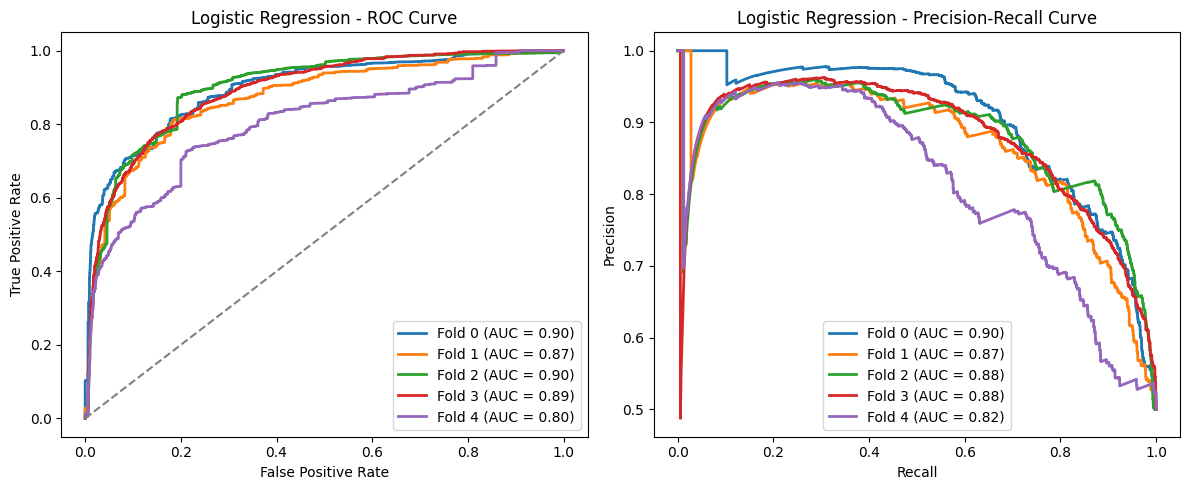

Model Loop:  33%|███▎      | 1/3 [00:05<00:10,  5.03s/it]

Running SVM



 Folds (SVM):   0%|          | 0/5 [00:00<?, ?it/s]

[LibSVM].........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -21309.107254, rho = -0.470510
nSV = 15832, nBSV = 15752
Total nSV = 15832
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -20909.982098, rho = -0.289393
nSV = 15543, nBSV = 15460
Total nSV = 15543
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -20950.244396, rho = -0.499144
nSV = 15664, nBSV = 15567
Total nSV = 15664
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -21291.875868, rho = -0.512015
nSV = 15736, nBSV = 15639
Total nSV = 15736
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -21966.422906, rho = -0.140637
nSV = 15565, nBSV = 15490
Total nSV = 15565
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -18561.367373, rho = -0.418691
nSV = 18614, nBSV = 18614
Total nSV = 18614


/home/ubuntu/anaconda3/envs/scgpt_conda/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(

 Folds (SVM):  20%|██        | 1/5 [04:08<16:33, 248.30s/it]

[0.         0.         0.         ... 0.99963262 0.99969385 1.        ]
[0.00000000e+00 6.12294881e-05 3.06147441e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]

[0.5        0.50007655 0.50009186 ... 1.         1.         1.        ]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 3.06147441e-04
 6.12294881e-05 0.00000000e+00]

0.902977058541989
0.9141717596101646
[LibSVM].........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -21373.043864, rho = -0.886269
nSV = 20000, nBSV = 20000
Total nSV = 20000
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -20631.700744, rho = -0.834146
nSV = 20000, nBSV = 20000
Total nSV = 20000
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -21228.312174, rho = -0.575280
nSV = 20000, nBSV = 20000
Total nSV = 20000
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -20856.066965, rho = -0.827366
nSV

/home/ubuntu/anaconda3/envs/scgpt_conda/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(

 Folds (SVM):  40%|████      | 2/5 [13:47<22:09, 443.17s/it]

[0.         0.         0.         ... 0.99587534 0.99633364 1.        ]
[0.         0.00137489 0.00152765 ... 1.         1.         1.        ]

[0.5        0.50003819 0.50007639 ... 1.         1.         1.        ]
[1.         1.         1.         ... 0.00152765 0.00137489 0.        ]

0.5892043092718815
0.6148553966183878
[LibSVM].........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -22047.333590, rho = -0.994148
nSV = 20000, nBSV = 20000
Total nSV = 20000
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -21996.868148, rho = -0.731153
nSV = 20000, nBSV = 20000
Total nSV = 20000
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -21943.343357, rho = -0.785630
nSV = 20000, nBSV = 20000
Total nSV = 20000
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -22706.652231, rho = -0.767030
nSV = 20000, nBSV = 20000
Total nSV = 20000
........

/home/ubuntu/anaconda3/envs/scgpt_conda/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(

 Folds (SVM):  60%|██████    | 3/5 [23:39<17:01, 510.79s/it]

[0.        0.        0.        ... 0.9950381 1.        1.       ]
[0.00000000e+00 1.77210704e-04 5.31632111e-04 ... 9.99822789e-01
 9.99822789e-01 1.00000000e+00]

[0.5        0.49995569 0.5        ... 1.         1.         1.        ]
[1.00000000e+00 9.99822789e-01 9.99822789e-01 ... 5.31632111e-04
 1.77210704e-04 0.00000000e+00]

0.6617983183919556
0.7143624016880985
[LibSVM].........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -22611.579583, rho = -0.810007
nSV = 20000, nBSV = 20000
Total nSV = 20000
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -20301.995306, rho = -0.771959
nSV = 20000, nBSV = 20000
Total nSV = 20000
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -20773.135327, rho = -0.806756
nSV = 20000, nBSV = 20000
Total nSV = 20000
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -21443.058785, rho = -0.795506
nSV = 20

/home/ubuntu/anaconda3/envs/scgpt_conda/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(

 Folds (SVM):  80%|████████  | 4/5 [33:27<09:01, 541.42s/it]

[0. 0. 0. ... 1. 1. 1.]
[0.00000000e+00 1.88821752e-04 4.72054381e-04 ... 9.93485650e-01
 9.97734139e-01 1.00000000e+00]

[0.5        0.49971661 0.49943289 ... 1.         1.         1.        ]
[1.00000000e+00 9.98867069e-01 9.97734139e-01 ... 4.72054381e-04
 1.88821752e-04 0.00000000e+00]

0.17867016308979702
0.3961727817332127
[LibSVM].........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -21280.498522, rho = -0.857586
nSV = 20000, nBSV = 20000
Total nSV = 20000
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -21450.362849, rho = -0.836660
nSV = 20000, nBSV = 20000
Total nSV = 20000
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -20467.810285, rho = -0.890719
nSV = 20000, nBSV = 20000
Total nSV = 20000
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -20221.559046, rho = -0.811250
nSV = 20000, nBSV = 20000
Total nSV = 20000
.....

/home/ubuntu/anaconda3/envs/scgpt_conda/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(

ROC Folds (SVM): 100%|██████████| 5/5 [43:04<00:00, 516.91s/it]


[0.00000000e+00 0.00000000e+00 2.73597811e-04 ... 9.98358413e-01
 9.98358413e-01 1.00000000e+00]
[0.         0.00683995 0.00683995 ... 0.99917921 1.         1.        ]

[0.5        0.50006841 0.50013684 ... 0.96153846 1.         1.        ]
[1.         1.         1.         ... 0.00683995 0.00683995 0.        ]

0.5917717797518905
0.6775083427935682



PR Folds (SVM): 100%|██████████| 5/5 [00:00<00:00, 1097.01it/s]


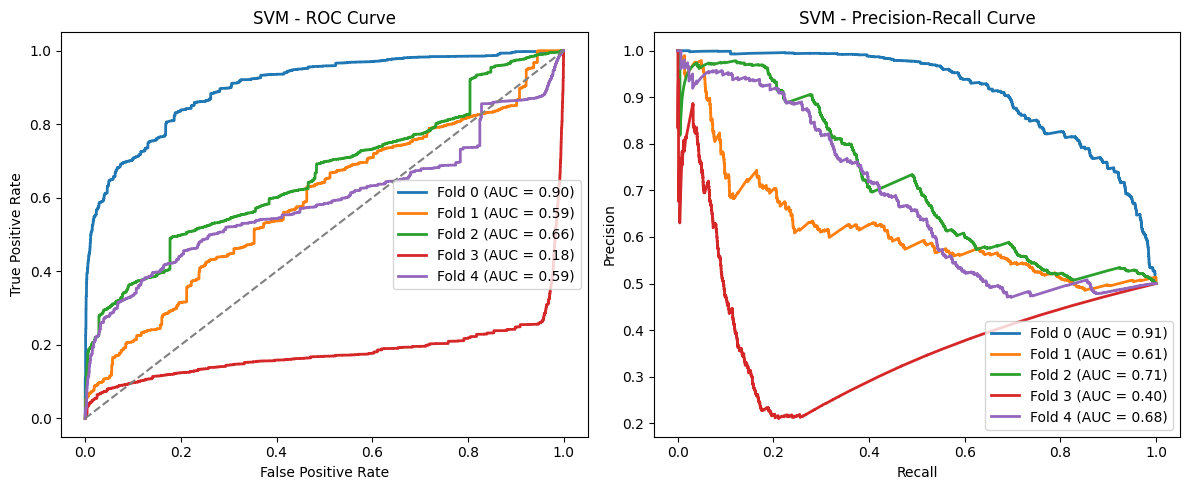

Model Loop:  67%|██████▋   | 2/3 [43:11<25:23, 1523.26s/it]

Running Random Forest



 Folds (Random Forest):  20%|██        | 1/5 [00:01<00:04,  1.07s/it]

[0.00000000e+00 1.22458976e-04 1.22458976e-04 2.44917952e-04
 2.44917952e-04 4.28606417e-04 5.51065393e-04 5.51065393e-04
 5.51065393e-04 6.73524369e-04 7.95983346e-04 9.18442322e-04
 1.10213079e-03 1.22458976e-03 1.28581925e-03 1.40827823e-03
 1.46950771e-03 1.59196669e-03 1.71442567e-03 1.77565516e-03
 1.89811413e-03 2.20426157e-03 2.20426157e-03 2.44917952e-03
 2.63286799e-03 2.75532697e-03 3.00024492e-03 3.18393338e-03
 3.42885133e-03 3.79622826e-03 4.10237570e-03 4.28606417e-03
 4.77590007e-03 4.83712956e-03 5.38819495e-03 6.00048984e-03
 6.98016165e-03 7.28630909e-03 7.59245653e-03 8.38843987e-03
 9.30688219e-03 9.42934117e-03 1.02865540e-02 1.08376194e-02
 1.21234386e-02 1.31643399e-02 1.43277002e-02 1.54298310e-02
 1.67156503e-02 1.81239285e-02 1.92872888e-02 2.03894195e-02
 2.19813862e-02 2.32672055e-02 2.48591722e-02 2.59613030e-02
 2.77981876e-02 3.00636787e-02 3.20842518e-02 3.35537595e-02
 3.56355621e-02 3.77785942e-02 4.02277737e-02 4.25544942e-02
 4.51261327e-02 4.812637


 Folds (Random Forest):  40%|████      | 2/5 [00:03<00:04,  1.66s/it]

[0.00000000e+00 1.52765047e-04 1.52765047e-04 1.52765047e-04
 1.52765047e-04 1.52765047e-04 1.52765047e-04 1.52765047e-04
 3.05530095e-04 3.05530095e-04 3.05530095e-04 3.05530095e-04
 3.05530095e-04 4.58295142e-04 4.58295142e-04 4.58295142e-04
 4.58295142e-04 4.58295142e-04 6.11060189e-04 6.11060189e-04
 6.11060189e-04 6.11060189e-04 6.11060189e-04 6.11060189e-04
 9.16590284e-04 9.16590284e-04 9.16590284e-04 9.16590284e-04
 1.22212038e-03 1.37488543e-03 1.83318057e-03 1.98594562e-03
 2.13871066e-03 2.44424076e-03 2.90253590e-03 3.05530095e-03
 3.20806599e-03 3.36083104e-03 3.51359609e-03 3.66636114e-03
 3.66636114e-03 3.97189123e-03 4.12465628e-03 4.27742133e-03
 4.43018637e-03 4.43018637e-03 4.73571647e-03 4.73571647e-03
 5.49954170e-03 5.95783685e-03 6.26336694e-03 6.26336694e-03
 6.41613199e-03 6.72166208e-03 7.48548732e-03 8.40207760e-03
 8.70760770e-03 9.16590284e-03 1.00824931e-02 1.05407883e-02
 1.14573786e-02 1.19156737e-02 1.23739688e-02 1.31377941e-02
 1.32905591e-02 1.405438


 Folds (Random Forest):  60%|██████    | 3/5 [00:05<00:03,  1.84s/it]

[0.00000000e+00 1.77210704e-04 1.77210704e-04 1.77210704e-04
 1.77210704e-04 3.54421407e-04 3.54421407e-04 3.54421407e-04
 3.54421407e-04 3.54421407e-04 7.08842814e-04 8.86053518e-04
 8.86053518e-04 1.06326422e-03 1.06326422e-03 1.06326422e-03
 1.06326422e-03 1.06326422e-03 1.06326422e-03 1.06326422e-03
 1.06326422e-03 1.06326422e-03 1.06326422e-03 1.24047492e-03
 1.24047492e-03 1.24047492e-03 1.24047492e-03 1.24047492e-03
 1.24047492e-03 1.24047492e-03 1.41768563e-03 1.77210704e-03
 1.77210704e-03 1.94931774e-03 1.94931774e-03 2.12652844e-03
 2.12652844e-03 2.12652844e-03 2.30373915e-03 2.48094985e-03
 2.48094985e-03 2.48094985e-03 2.48094985e-03 2.65816055e-03
 2.65816055e-03 3.01258196e-03 3.36700337e-03 3.36700337e-03
 3.54421407e-03 3.54421407e-03 3.54421407e-03 4.25305688e-03
 4.60747829e-03 4.60747829e-03 4.96189970e-03 5.67074251e-03
 5.67074251e-03 6.55679603e-03 7.26563884e-03 7.79727096e-03
 8.86053518e-03 9.03774588e-03 9.74658869e-03 1.02782208e-02
 1.13414850e-02 1.187311


 Folds (Random Forest):  80%|████████  | 4/5 [00:07<00:01,  1.96s/it]

[0.00000000e+00 0.00000000e+00 9.44108761e-05 9.44108761e-05
 9.44108761e-05 9.44108761e-05 9.44108761e-05 9.44108761e-05
 4.72054381e-04 4.72054381e-04 4.72054381e-04 4.72054381e-04
 4.72054381e-04 5.66465257e-04 6.60876133e-04 7.55287009e-04
 7.55287009e-04 7.55287009e-04 8.49697885e-04 8.49697885e-04
 9.44108761e-04 9.44108761e-04 1.03851964e-03 1.13293051e-03
 1.22734139e-03 1.22734139e-03 1.32175227e-03 1.51057402e-03
 1.88821752e-03 1.88821752e-03 2.07703927e-03 2.17145015e-03
 2.17145015e-03 2.54909366e-03 2.73791541e-03 2.83232628e-03
 2.92673716e-03 3.20996979e-03 3.30438066e-03 3.30438066e-03
 3.39879154e-03 3.68202417e-03 4.05966767e-03 4.24848943e-03
 4.24848943e-03 4.53172205e-03 4.81495468e-03 4.90936556e-03
 5.00377644e-03 5.57024169e-03 6.13670695e-03 6.41993958e-03
 6.70317221e-03 7.08081571e-03 7.83610272e-03 8.30815710e-03
 8.78021148e-03 9.44108761e-03 1.01019637e-02 1.07628399e-02
 1.15181269e-02 1.25566465e-02 1.32175227e-02 1.42560423e-02
 1.53889728e-02 1.689954


ROC Folds (Random Forest): 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.73597811e-04
 2.73597811e-04 5.47195622e-04 5.47195622e-04 5.47195622e-04
 5.47195622e-04 5.47195622e-04 5.47195622e-04 5.47195622e-04
 5.47195622e-04 5.47195622e-04 5.47195622e-04 5.47195622e-04
 5.47195622e-04 5.47195622e-04 5.47195622e-04 5.47195622e-04
 5.47195622e-04 5.47195622e-04 8.20793434e-04 8.20793434e-04
 8.20793434e-04 1.09439124e-03 1.09439124e-03 1.09439124e-03
 1.09439124e-03 1.09439124e-03 1.36798906e-03 1.36798906e-03
 1.36798906e-03 1.36798906e-03 1.64158687e-03 1.91518468e-03
 1.91518468e-03 1.91518468e-03 2.18878249e-03 2.18878249e-03
 2.18878249e-03 2.18878249e-03 2.18878249e-03 2.46238030e-03
 3.00957592e-03 3.28317373e-03 3.28317373e-03 3.83036936e-03
 4.37756498e-03 4.92476060e-03 4.92476060e-03 5.47195622e-03
 5.47195622e-03 6.29274966e-03 6.56634747e-03 6.83994528e-03
 7.11354309e-03 8.20793434e-03 8.20793434e-03 9.02872777e-03
 9.84952120e-03 1.03967168e-02 1.14911081e-02 1.28590971e-02
 1.39534884e-02 1.614227


PR Folds (Random Forest): 100%|██████████| 5/5 [00:00<00:00, 1469.11it/s]


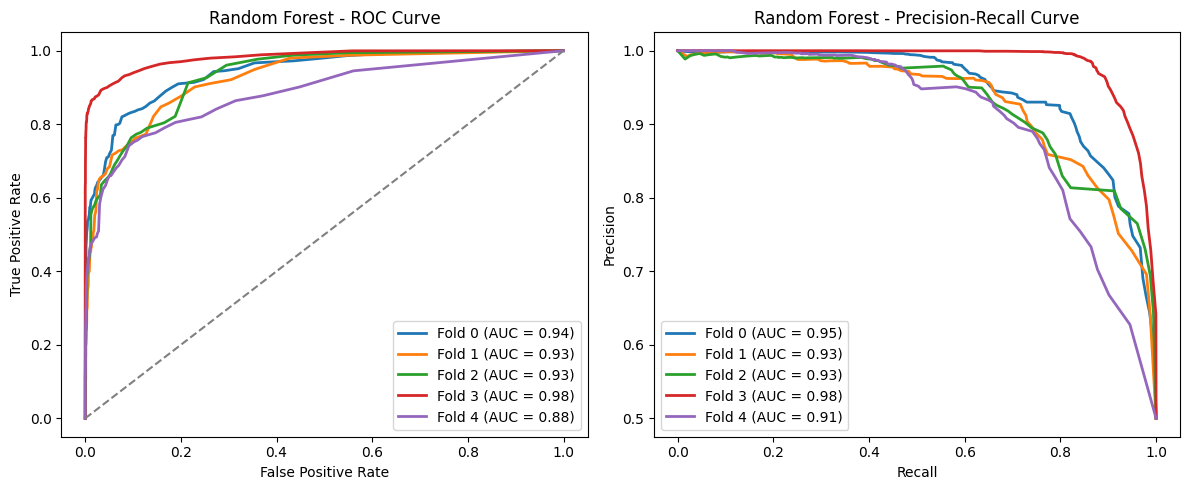

Model Loop: 100%|██████████| 3/3 [43:21<00:00, 867.18s/it] 


,Logistic Regression_AUROC_per_fold,Logistic Regression_AUPRC_per_fold,SVM_AUROC_per_fold,SVM_AUPRC_per_fold,Random Forest_AUROC_per_fold,Random Forest_AUPRC_per_fold
0,0.897954,0.904853,0.902977,0.914172,0.941770,0.947354
1,0.871491,0.868542,0.589204,0.614855,0.925593,0.929419
2,0.899296,0.882593,0.661798,0.714362,0.930891,0.931357
3,0.892043,0.877987,0.178670,0.396173,0.981134,0.984023
4,0.802321,0.816077,0.591772,0.677508,0.883686,0.905834


In [3]:
run_modeling_pipeline_from_csv(fold_numbers=[0,1,2,3,4])

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc
)
import numpy as np
from tqdm import tqdm  # <-- added tqdm

FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']

LABEL = ['Same_Complex']

def run_modeling_pipeline_from_csv(fold_numbers, label_col='Same_Complex'):
    """
    Trains Logistic Regression, SVM, and Random Forest across precomputed CSV folds
    and plots ROC + PR curves.

    Parameters:
        fold_numbers (List[int]): List of fold identifiers (e.g., [1, 2, 3, 4, 5]).
        label_col (str): Name of the label column in the CSV files.

    File format assumption:
        - For fold i:
            - X_y_train_i.csv
            - X_y_test_i.csv
        - Each CSV contains feature columns and a 'Label' column.
    """


    print("Starting logsitic regression, SVM and random forest")

    models = {
        "SGD": SGDClassifier(loss='log_loss', max_iter=10000, random_state=42),
        "LinearSVC": LinearSVC(max_iter=10000, verbose=0, random_state=42)
}

    model_results = pd.DataFrame()

    for model_name, model in tqdm(models.items(), desc="Model Loop"):  # <-- wrapped with tqdm
        print(f"Running {model_name}")
        plt.figure(figsize=(12, 5))

        roc = []
        pr = []
        precisions = []
        recalls = []

        # ROC Curve
        plt.subplot(1, 2, 1)
        for i in tqdm(fold_numbers, desc=f"ROC Folds ({model_name})"):  # <-- wrapped with tqdm
            data = pd.read_csv(f'balanced_group_stratified_fold_{i}.csv')
            data = data.copy()
            ALL = FEATURES + LABEL
            train_df = data[data['Test']==False][ALL].dropna()
            test_df = data[data['Test']==True][ALL].dropna()

            X_train = train_df[FEATURES]
            y_train = train_df[LABEL[0]]
            X_test = test_df[FEATURES]
            y_test = test_df[LABEL[0]]

            model.fit(X_train, y_train)
            #y_score = model.predict_proba(X_test)[:, 1]
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                decision_scores = model.decision_function(X_test)
                # Normalize to [0, 1] for use with ROC/PR curve
                y_score = MinMaxScaler().fit_transform(decision_scores.reshape(-1, 1)).ravel()
            else:
                raise ValueError(f"Model {model_name} does not support probability estimation.")

            fpr, tpr, _ = roc_curve(y_test, y_score)
            precision, recall, _ = precision_recall_curve(y_test, y_score)
            print(fpr)
            print(tpr)
            precisions.append(precision)
            recalls.append(recall)
            print('')
            print(precision)
            print(recall)
            print('')
            roc_auc = auc(fpr, tpr)
            print(roc_auc)
            pr_auc = auc(recall, precision)
            print(pr_auc)
            pr.append(pr_auc)
            roc.append(roc_auc)
            plt.plot(fpr, tpr, lw=2, label=f"Fold {i} (AUC = {roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"{model_name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()

        # PR Curve
        plt.subplot(1, 2, 2)
        for i in tqdm(fold_numbers, desc=f"PR Folds ({model_name})"):  # <-- wrapped with tqdm
            # data = pd.read_csv(f'balanced_group_stratified_fold_{i}.csv')
            # ALL = FEATURES + LABEL
            # train_df = data[data['Test']==False][ALL].dropna()
            # test_df = data[data['Test']==True][ALL].dropna()

            # X_train = train_df[FEATURES]
            # y_train = train_df[LABEL[0]]
            # X_test = test_df[FEATURES]
            # y_test = test_df[LABEL[0]]

            # model.fit(X_train, y_train)
            # y_score = model.predict_proba(X_test)[:, 1]

            # precision, recall, _ = precision_recall_curve(y_test, y_score)
            # pr_auc = auc(recall, precision)
            # pr.append(pr_auc)

            precision = precisions[i]
            recall = recalls[i]
            pr_auc = auc(recall, precision)
            plt.plot(recall, precision, lw=2, label=f"Fold {i} (AUC = {pr_auc:.2f})")

        model_results[f'{model_name}_AUROC_per_fold'] = roc
        model_results[f'{model_name}_AUPRC_per_fold'] = pr

        plt.title(f"{model_name} - Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{model_name}_all_features_cs_roc_pr_balanced_stratified_group_sgd_linsvc.png", dpi=300)
        plt.show()

    display(model_results)

    model_results = model_results.reset_index()
    model_results.rename(columns={'index':'Fold'}, inplace=True)
    model_results.to_csv('all_features_cosine_similarity_model_results_balanced_group_stratified_sgd_linsvc_.csv', index=False)


Starting logsitic regression, SVM and random forest


Model Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Running SGD



 Folds (SGD):  20%|██        | 1/5 [00:00<00:01,  2.63it/s]

[0.         0.         0.         ... 0.99963262 0.99975508 1.        ]
[0.00000000e+00 6.12294881e-05 1.22458976e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]

[0.5        0.50001531 0.50003062 ... 1.         1.         1.        ]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.22458976e-04
 6.12294881e-05 0.00000000e+00]

0.8962269161230694
0.9037823757734009



 Folds (SGD):  40%|████      | 2/5 [00:00<00:01,  1.95it/s]

[0.         0.         0.         ... 0.99725023 0.99786129 1.        ]
[0.00000000e+00 1.52765047e-04 3.05530095e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]

[0.5        0.50003819 0.50007639 ... 1.         1.         1.        ]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 3.05530095e-04
 1.52765047e-04 0.00000000e+00]

0.8727819313254601
0.8696333123062248



 Folds (SGD):  60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

[0.         0.         0.         ... 0.99432926 0.99468368 1.        ]
[0.00000000e+00 1.77210704e-04 3.01258196e-03 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]

[0.5        0.50004431 0.50008862 ... 1.         1.         1.        ]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 3.01258196e-03
 1.77210704e-04 0.00000000e+00]

0.8997073463995686
0.8845746646428347



 Folds (SGD):  80%|████████  | 4/5 [00:02<00:00,  1.70it/s]

[0.         0.         0.         ... 0.99792296 0.99820619 1.        ]
[0.00000000e+00 8.49697885e-04 1.69939577e-03 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]

[0.5        0.5000236  0.50004721 ... 1.         1.         1.        ]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.69939577e-03
 8.49697885e-04 0.00000000e+00]

0.8984328026310685
0.8854986646433555



ROC Folds (SGD): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


[0.         0.         0.         ... 0.99507524 0.99562244 1.        ]
[0.         0.00109439 0.00218878 ... 1.         1.         1.        ]

[0.5        0.50006841 0.50013684 ... 1.         1.         1.        ]
[1.         1.         1.         ... 0.00218878 0.00109439 0.        ]

0.8009156356844904
0.8189911797742088



PR Folds (SGD): 100%|██████████| 5/5 [00:00<00:00, 1124.18it/s]


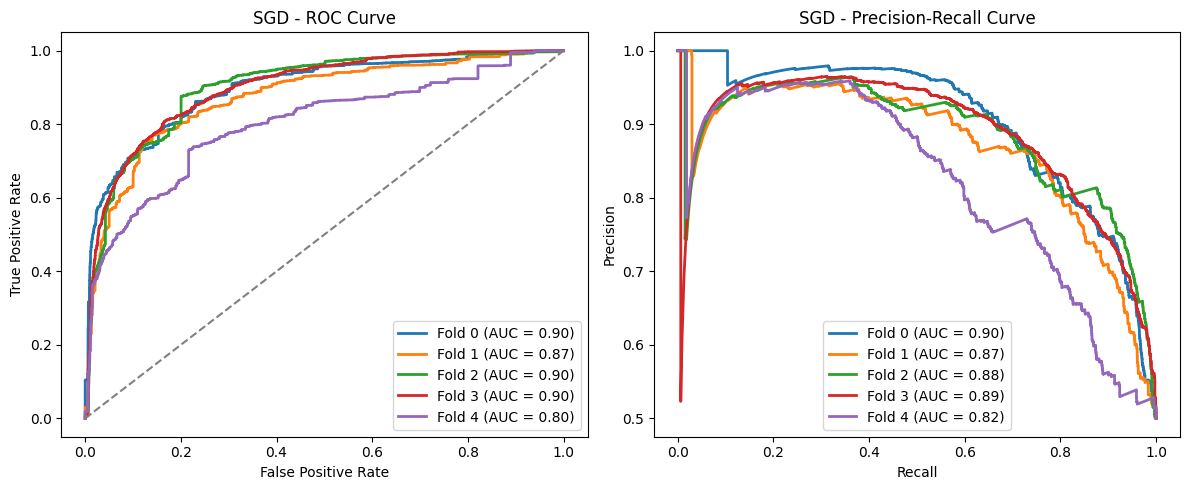

Model Loop:  50%|█████     | 1/2 [00:04<00:04,  4.10s/it]

Running LinearSVC



 Folds (LinearSVC):  20%|██        | 1/5 [00:00<00:01,  2.23it/s]

[0.         0.         0.         ... 0.99902033 0.99914279 1.        ]
[0.00000000e+00 6.12294881e-05 1.22458976e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]

[0.5        0.50001531 0.50003062 ... 1.         1.         1.        ]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.22458976e-04
 6.12294881e-05 0.00000000e+00]

0.8976404242749142
0.9046599460691329



 Folds (LinearSVC):  40%|████      | 2/5 [00:01<00:02,  1.45it/s]

[0.         0.         0.         ... 0.99465322 0.99526428 1.        ]
[0.00000000e+00 6.11060189e-04 7.63825237e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]

[0.5        0.50003819 0.50007639 ... 1.         1.         1.        ]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 7.63825237e-04
 6.11060189e-04 0.00000000e+00]

0.872139552667722
0.8694568846536007



 Folds (LinearSVC):  60%|██████    | 3/5 [00:02<00:01,  1.28it/s]

[0.         0.         0.         ... 0.99751905 0.99751905 1.        ]
[0.00000000e+00 1.77210704e-04 2.83537126e-03 ... 9.97164629e-01
 1.00000000e+00 1.00000000e+00]

[0.5        0.50004431 0.50008862 ... 1.         1.         1.        ]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 2.83537126e-03
 1.77210704e-04 0.00000000e+00]

0.89864700271632
0.8845882159781967



 Folds (LinearSVC):  80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

[0.00000000e+00 0.00000000e+00 4.72054381e-04 ... 9.98489426e-01
 9.98678248e-01 1.00000000e+00]
[0.00000000e+00 8.49697885e-04 8.49697885e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]

[0.5        0.5000236  0.50004721 ... 0.64285714 1.         1.        ]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 8.49697885e-04
 8.49697885e-04 0.00000000e+00]

0.8666834375513413
0.8527583626532002



ROC Folds (LinearSVC): 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


[0.         0.         0.         ... 0.98987688 0.99042408 1.        ]
[0.         0.00109439 0.00164159 ... 1.         1.         1.        ]

[0.5        0.50006841 0.50013684 ... 1.         1.         1.        ]
[1.         1.         1.         ... 0.00136799 0.00109439 0.        ]

0.8007147976742315
0.816263791902484



PR Folds (LinearSVC): 100%|██████████| 5/5 [00:00<00:00, 1176.00it/s]


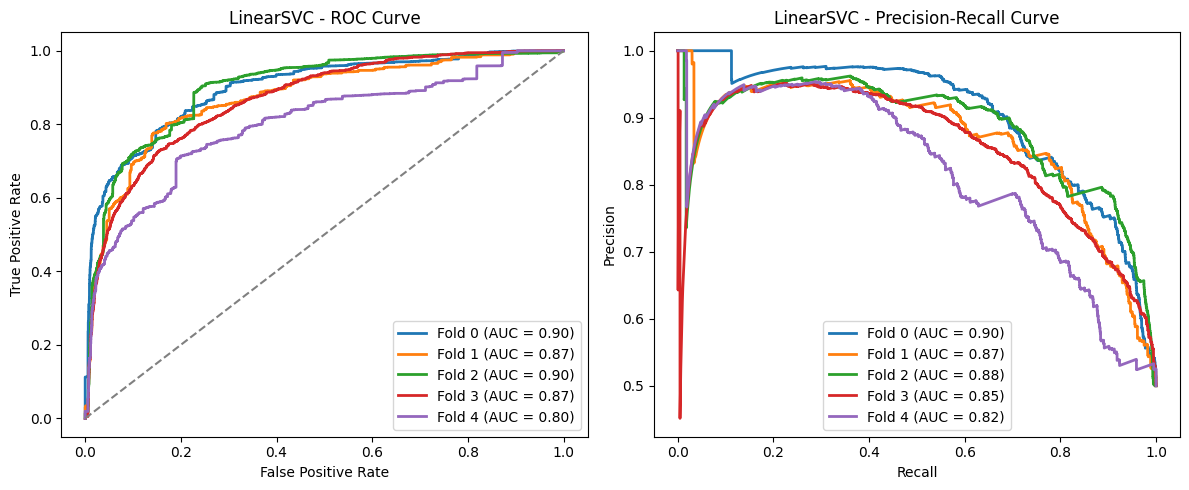

Model Loop: 100%|██████████| 2/2 [00:09<00:00,  4.65s/it]


,SGD_AUROC_per_fold,SGD_AUPRC_per_fold,LinearSVC_AUROC_per_fold,LinearSVC_AUPRC_per_fold
0,0.896227,0.903782,0.897640,0.904660
1,0.872782,0.869633,0.872140,0.869457
2,0.899707,0.884575,0.898647,0.884588
3,0.898433,0.885499,0.866683,0.852758
4,0.800916,0.818991,0.800715,0.816264


In [26]:
run_modeling_pipeline_from_csv(fold_numbers=[0,1,2,3,4])

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from tpot import TPOTClassifier
import numpy as np

FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']

LABEL = ['Same_Complex']

def run_modeling_pipeline_from_csv(fold_numbers, label_col='Same_Complex', run_tpot=True):
    print("Starting model pipeline...")

    # models = {
    #     "Logistic Regression": LogisticRegression(max_iter=10000),
    #     "SVM": SVC(probability=True, max_iter=10000, verbose=False),
    #     "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1),
    #     "SGD": SGDClassifier(loss='log_loss', max_iter=10000, random_state=42),
    #     "LinearSVC": LinearSVC(max_iter=10000, verbose=0, random_state=42)
    # }

    model_results = pd.DataFrame()

    # for model_name, model in tqdm(models.items(), desc="Model Loop"):
    #     print(f"\nRunning {model_name}")
    #     plt.figure(figsize=(12, 5))

    #     roc = []
    #     pr = []
    #     precisions = []
    #     recalls = []

    #     # ROC Curve
    #     plt.subplot(1, 2, 1)
    #     for i in tqdm(fold_numbers, desc=f"ROC Folds ({model_name})"):
    #         data = pd.read_csv(f'balanced_group_stratified_fold_{i}.csv')
    #         data = data.copy()
    #         ALL = FEATURES + LABEL
    #         train_df = data[data['Test']==False][ALL].dropna()
    #         test_df = data[data['Test']==True][ALL].dropna()

    #         X_train = train_df[FEATURES]
    #         y_train = train_df[label_col]
    #         X_test = test_df[FEATURES]
    #         y_test = test_df[label_col]

    #         model.fit(X_train, y_train)

    #         if hasattr(model, "predict_proba"):
    #             y_score = model.predict_proba(X_test)[:, 1]
    #         elif hasattr(model, "decision_function"):
    #             decision_scores = model.decision_function(X_test)
    #             y_score = MinMaxScaler().fit_transform(decision_scores.reshape(-1, 1)).ravel()
    #         else:
    #             raise ValueError(f"{model_name} does not support probability or score output.")

    #         fpr, tpr, _ = roc_curve(y_test, y_score)
    #         precision, recall, _ = precision_recall_curve(y_test, y_score)

    #         precisions.append(precision)
    #         recalls.append(recall)

    #         roc_auc = auc(fpr, tpr)
    #         pr_auc = auc(recall, precision)

    #         pr.append(pr_auc)
    #         roc.append(roc_auc)

    #         plt.plot(fpr, tpr, lw=2, label=f"Fold {i} (AUC = {roc_auc:.2f})")

    #     plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    #     plt.title(f"{model_name} - ROC Curve")
    #     plt.xlabel("False Positive Rate")
    #     plt.ylabel("True Positive Rate")
    #     plt.legend()

    #     # PR Curve
    #     plt.subplot(1, 2, 2)
    #     for j, i in enumerate(fold_numbers):
    #         precision = precisions[j]
    #         recall = recalls[j]
    #         pr_auc = auc(recall, precision)
    #         plt.plot(recall, precision, lw=2, label=f"Fold {i} (AUC = {pr_auc:.2f})")

    #     model_results[f'{model_name}_AUROC_per_fold'] = roc
    #     model_results[f'{model_name}_AUPRC_per_fold'] = pr

    #     plt.title(f"{model_name} - Precision-Recall Curve")
    #     plt.xlabel("Recall")
    #     plt.ylabel("Precision")
    #     plt.legend()

    #     plt.tight_layout()
    #     plt.savefig(f"{model_name}_roc_pr_balanced_stratified_group.png", dpi=300)
    #     plt.show()

    # --- TPOT AutoML ---
    if run_tpot:
        print("\nRunning TPOT AutoML on all folds...")
        roc = []
        pr = []
        model_names = []
        parameter_summaries = []

        for i in tqdm(fold_numbers, desc="TPOT Folds"):
            data = pd.read_csv(f'balanced_group_stratified_fold_{i}.csv')
            data = data.copy()
            ALL = FEATURES + LABEL
            train_df = data[data['Test']==False][ALL].dropna()
            test_df = data[data['Test']==True][ALL].dropna()

            X_train = train_df[FEATURES]
            y_train = train_df[label_col]
            X_test = test_df[FEATURES]
            y_test = test_df[label_col]

            tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, random_state=42, n_jobs=-1)
            tpot.fit(X_train, y_train)

            # TPOT Metadata
            final_step_name, final_model = tpot.fitted_pipeline_.steps[-1]
            model_name = final_model.__class__.__name__
            model_params = final_model.get_params()
            model_params_str = str(model_params)
            model_names.append(model_name)
            parameter_summaries.append(model_params_str)
            
            # Save pipeline and output
            tpot.export(f'tpot_best_pipeline_fold_{i}.py')
            print(f"TPOT best pipeline for fold {i} exported.")

            y_score = tpot.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_score)
            precision, recall, _ = precision_recall_curve(y_test, y_score)

            roc_auc = auc(fpr, tpr)
            pr_auc = auc(recall, precision)

            roc.append(roc_auc)
            pr.append(pr_auc)

            # Save individual plots
            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.2f}")
            plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
            plt.title(f"TPOT - ROC Curve (Fold {i})")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(recall, precision, lw=2, label=f"AUC = {pr_auc:.2f}")
            plt.title(f"TPOT - Precision-Recall Curve (Fold {i})")
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.legend()

            plt.tight_layout()
            plt.savefig(f"TPOT_fold_{i}_roc_pr.png", dpi=300)
            plt.show()

        model_results['TPOT_AUROC_per_fold'] = roc
        model_results['TPOT_AUPRC_per_fold'] = pr
        model_results['TPOT_Model_Name'] = model_names
        model_results['TPOT_Model_Params'] = parameter_summaries

    model_results = model_results.reset_index(drop=True)
    model_results.to_csv('model_results_balanced_group_stratified_TPOT.csv', index=False)
    return model_results

ModuleNotFoundError: No module named 'tpot'

In [2]:
! which tpot

/home/ubuntu/.local/bin/tpot


In [1]:
! which conda

In [2]:
! which tpot

/home/ubuntu/.local/bin/tpot
